# Контекст

В далёком 2148 году мир переживает последствия кризиса и глобальной войны. Постапокалиптическую пустошь населяют безжалостные воины, но все ещё есть место для честных предпринимателей. 

Вы работаете в Компании, управляющей сетью магазинов, которая торгует различными товарами, пользующимися спросом в данной реальности.

Нам доступны исторические данные о продажах за 2 года и данные о характеристиках магазинов.


In [715]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [716]:
path_to_data = 'Data_science/'

In [717]:
sales = pd.read_parquet(path_to_data + 'sales.parquet', engine='pyarrow')
shops = pd.read_parquet(path_to_data + 'shops.parquet', engine='pyarrow')
cities = pd.read_parquet(path_to_data + 'cities.parquet', engine='pyarrow')

# 1. Around the Data

## 1.1 Данные по продажам - `sales`

- `shop_id` - уникальный идентификатор магазина
- `owner` - владелец магазига
- `number_of_counters` - количество работающих продавцов
- `total_items_sold` - суммарные продажи в этот день в этом магазине в штуках

In [718]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


### 1.1.1 `sales` analyse

In [719]:
sales['year'] = sales.date.dt.year
sales['month'] = sales.date.dt.month
sales['day'] = sales.date.dt.day
sales['doy'] = sales.date.dt.dayofyear
sales['day_name'] = sales.date.dt.day_name()
sales['month_name'] = sales.date.dt.month_name()
sales['is_weekend'] =sales['date'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

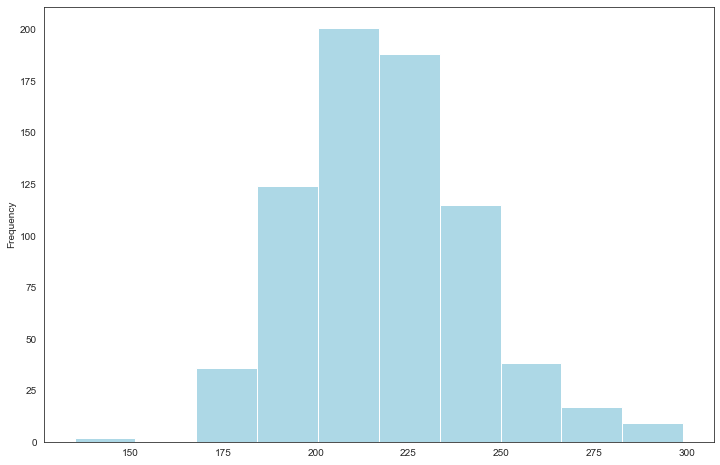

In [720]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sales.groupby(by=['date']).median()['total_items_sold'].plot.hist(ax=ax, color='lightblue')
plt.show()

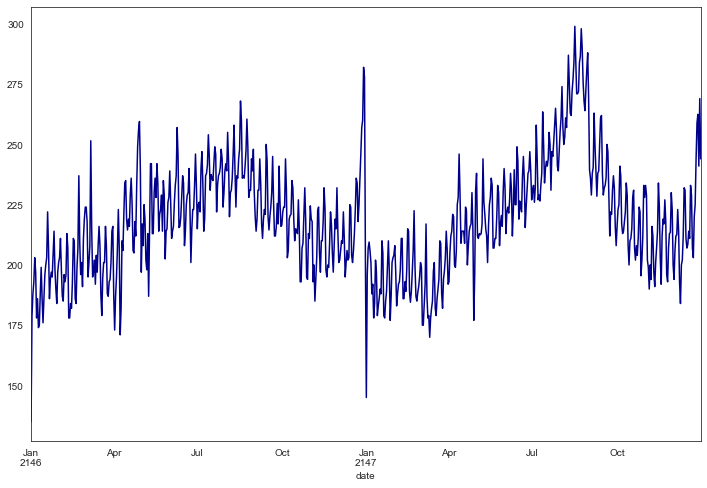

In [721]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sales.groupby(by=['date']).median()['total_items_sold'].plot(ax=ax, color='darkblue')
plt.show()

Нормальное распределение продаж с выбросами в начале `2147` года.

#### 1.1.1.1 Общее количество продаж `total_items_sold`  по `month_name` в разрезе `shop_id`

In [722]:
shop_id_Grouped_month_name = (sales.groupby(by=['shop_id', 'month_name'])
 .sum()[['number_of_counters', 'total_items_sold']]
 )

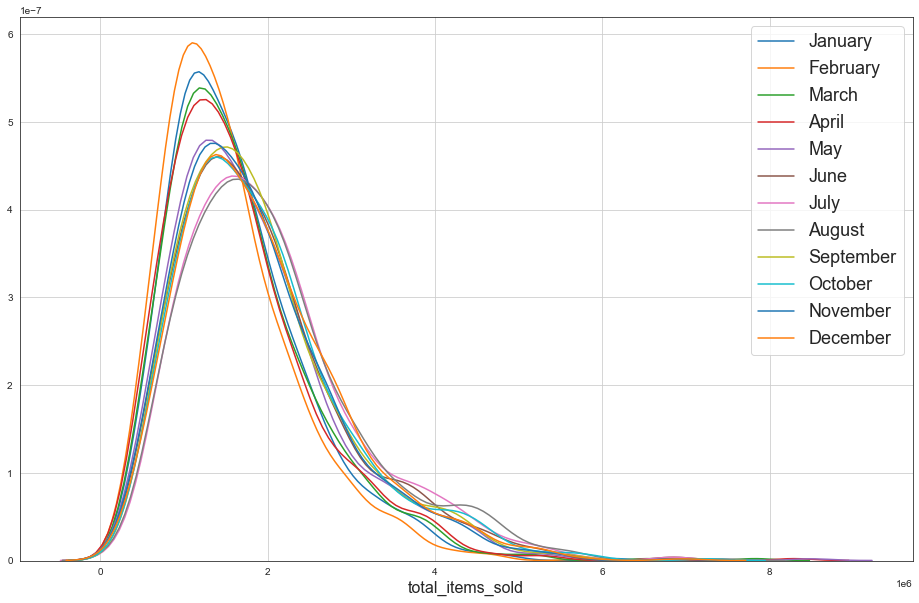

In [723]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for month in pd.unique(sales['month_name']):
    sns.distplot(shop_id_Grouped_month_name.query(f'month_name=="{month}"')['total_items_sold'].values,
                 ax=ax,
                 label=month,
                 hist=False,
                 hist_kws = {'color': 'lightblue', 
                             'edgecolor': 'black',
                             'linewidth': 2, 
                             'linestyle': '--', 
                             'alpha': 1})
ax.legend(fontsize=18)
ax.grid()
ax.set_xlabel('total_items_sold', fontsize=16)
plt.show()

#### 1.1.1.2 Среднее количество продаж `total_items_sold`  по `month_name` в разрезе `shop_id`

In [724]:
shop_id_Grouped_month_name_mean = (sales.groupby(by=['shop_id', 'month_name'])
 .mean()[['number_of_counters', 'total_items_sold']]
 )

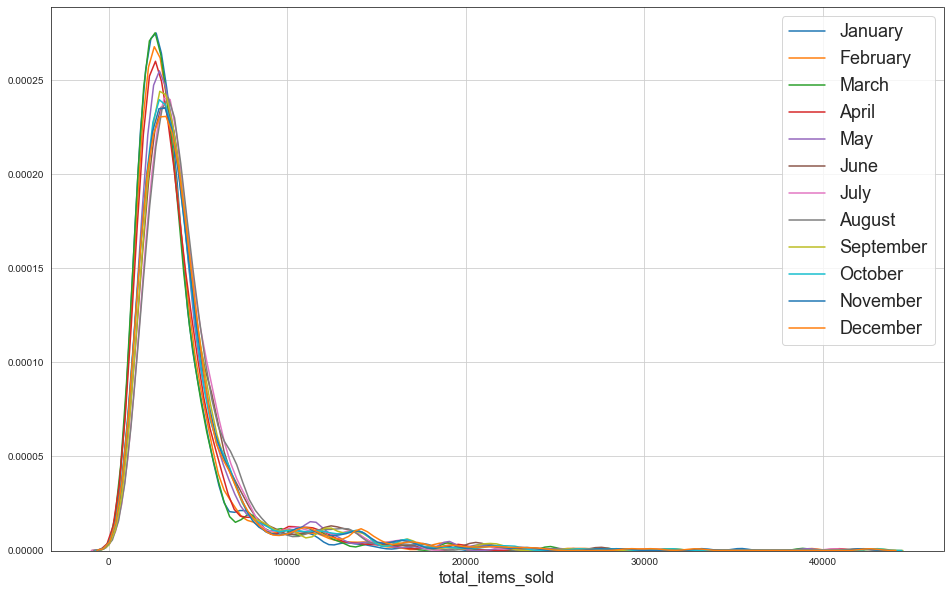

In [725]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for month in pd.unique(sales['month_name']):
    sns.distplot(shop_id_Grouped_month_name_mean.query(f'month_name=="{month}"')['total_items_sold'].values,
                 ax=ax,
                 label=month,
                 hist=False,
                 hist_kws = {'color': 'lightblue', 
                             'edgecolor': 'black',
                             'linewidth': 2, 
                             'linestyle': '--', 
                             'alpha': 1})
ax.legend(fontsize=18)
ax.grid()
ax.set_xlabel('total_items_sold', fontsize=16)
plt.show()

#### 1.1.1.3 Среднее количество продаж `total_items_sold`  по `year` в разрезе `shop_id`

In [726]:
mean_by_year = (
    sales.groupby(by=['shop_id', 'year'])
    .mean()[['number_of_counters', 'total_items_sold']]
 )

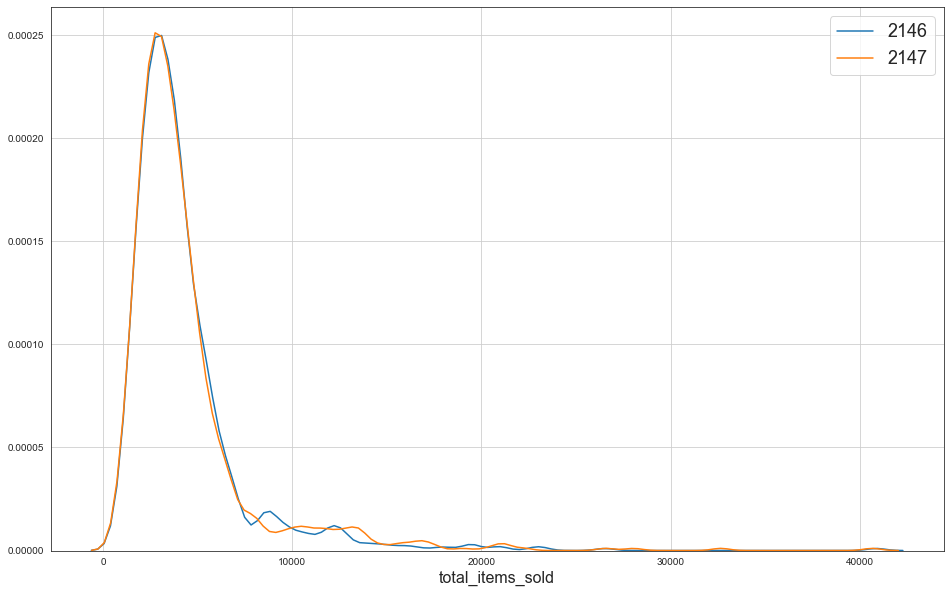

In [727]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for year in pd.unique(sales['year']):
    sns.distplot(mean_by_year.query(f'year=="{year}"')['total_items_sold'].values,
                 ax=ax,
                 label=year,
                 hist=False,
                 hist_kws = {'color': 'lightblue', 
                             'edgecolor': 'black',
                             'linewidth': 2, 
                             'linestyle': '--', 
                             'alpha': 1})
ax.legend(fontsize=18)
ax.grid()
ax.set_xlabel('total_items_sold', fontsize=16)
plt.show()

#### 1.1.1.4 `total_items_sold` в разрезе по `day_name` и `goods_type`

In [728]:
grouped_sales = sales.groupby(['shop_id','day_name','goods_type']).median()
grouped_sales

number_of_counters  total_items_sold  \
shop_id day_name  goods_type                                             
0       Friday    Бензак                         4.0           15289.5   
                  Броня и одежда                 4.0               2.0   
                  Съедобный хлам                 4.0               9.0   
                  Хлам                           4.0              18.5   
        Monday    Бензак                         4.0           16168.0   
...                                              ...               ...   
844     Wednesday Патроны                       10.0             863.0   
                  Солярка                       10.0            8290.0   
                  Съедобный хлам                10.0             419.0   
                  Хлам                          10.0             172.0   
                  Ядер-Кола                     10.0             367.0   

                                    year  month   day    doy  is_weekend  
shop_id day_name  goods_type                                              
0       Friday    Бензак          2146.5    7.0  15.5  185.0         0.0  
                  Броня и одежда  2146.0    1.0  18.0   21.0         0.0  
                  Съедобный хлам  2146.0    2.0  14.0   49.0         0.0  
                  Хлам            2146.0    2.0  18.0   38.5         0.0  
        Monday    Бензак          2146.5    6.5  16.0  181.0         0.0  
...                                  ...    ...   ...    ...         ...  
844     Wednesday Патроны         2147.0    7.0  15.0  208.0         0.0  
                  Солярка         2146.0    7.0  16.0  186.0         0.0  
                  Съедобный хлам  2146.0    7.0  16.0  186.0         0.0  
                  Хлам            2146.0    7.0  16.0  186.0         0.0  
                  Ядер-Кола       2147.0    7.0  15.0  208.0         0.0  

[57490 rows x 7 columns]

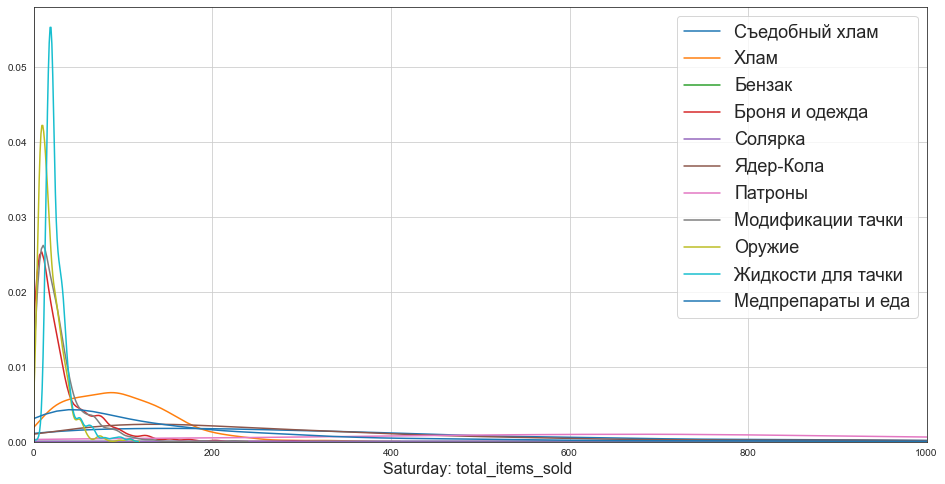

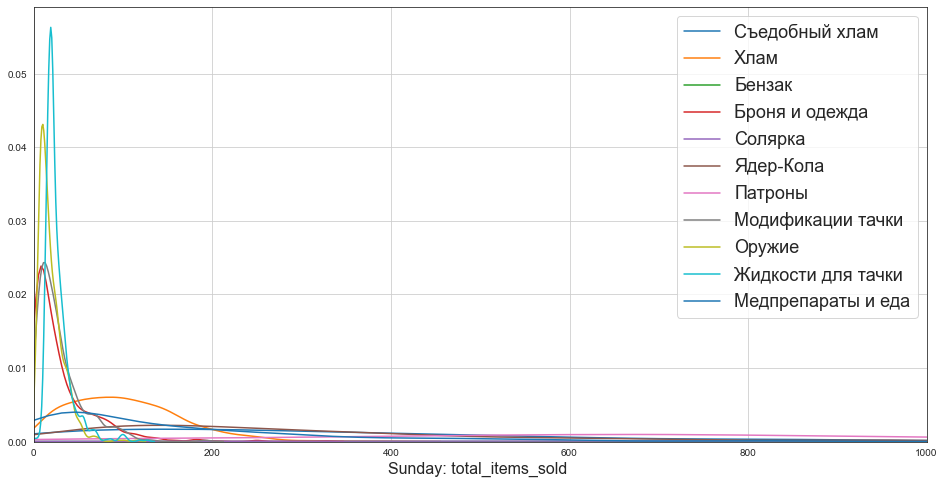

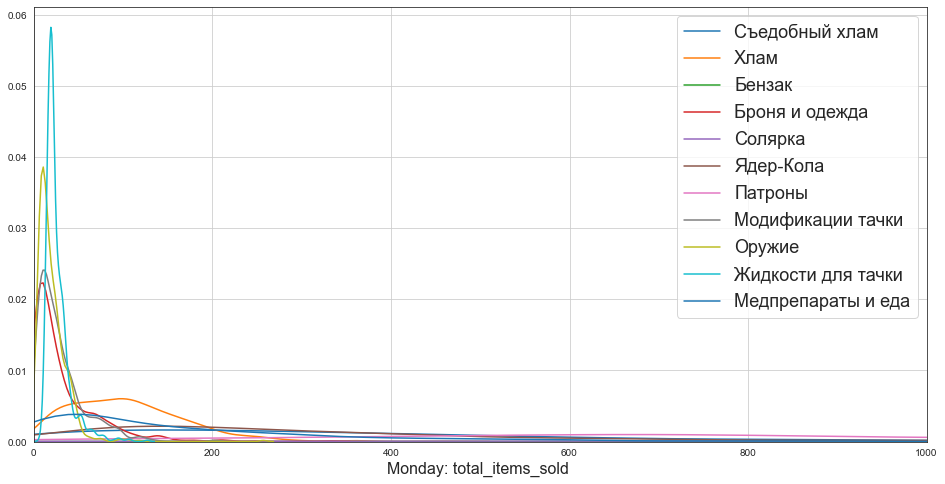

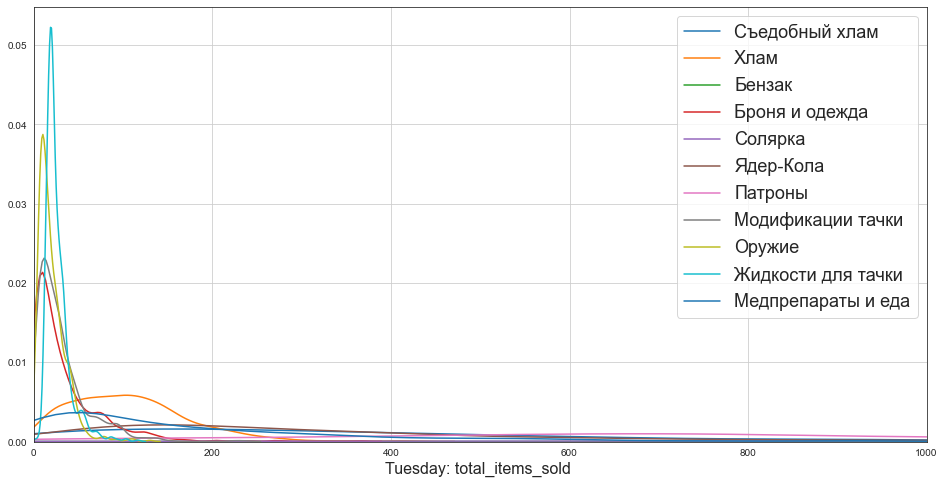

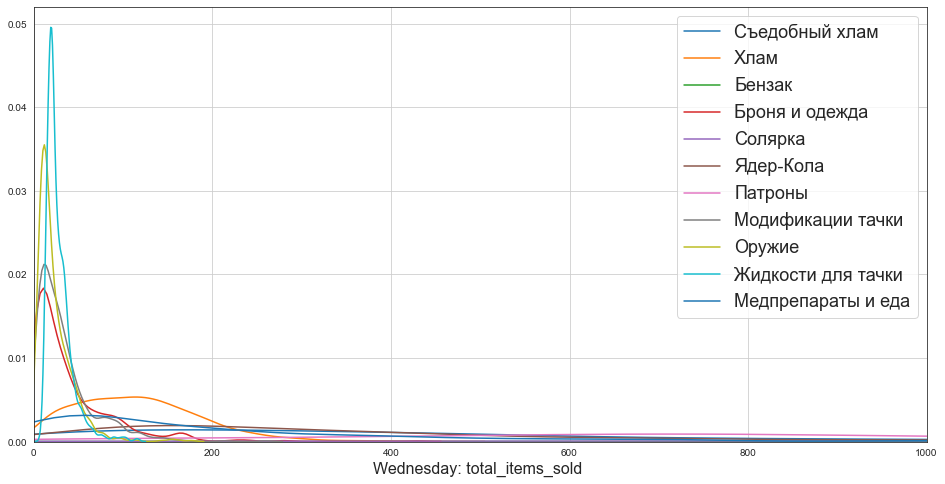

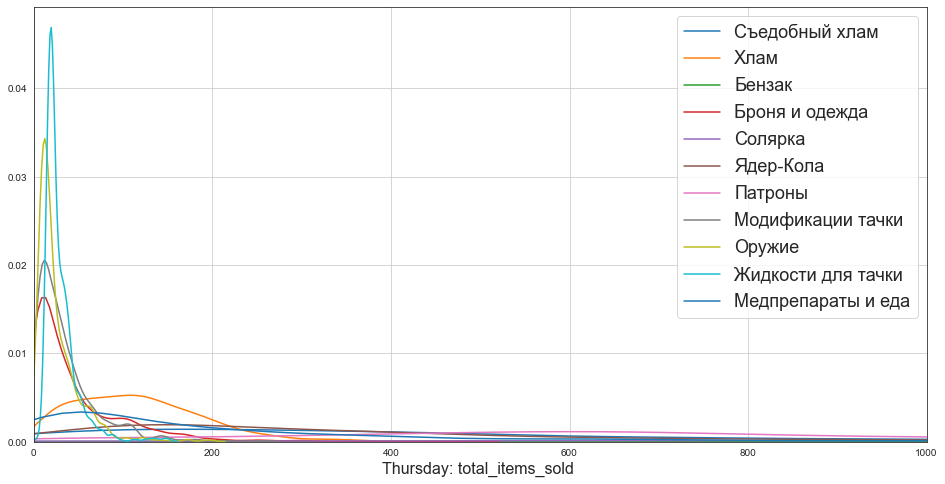

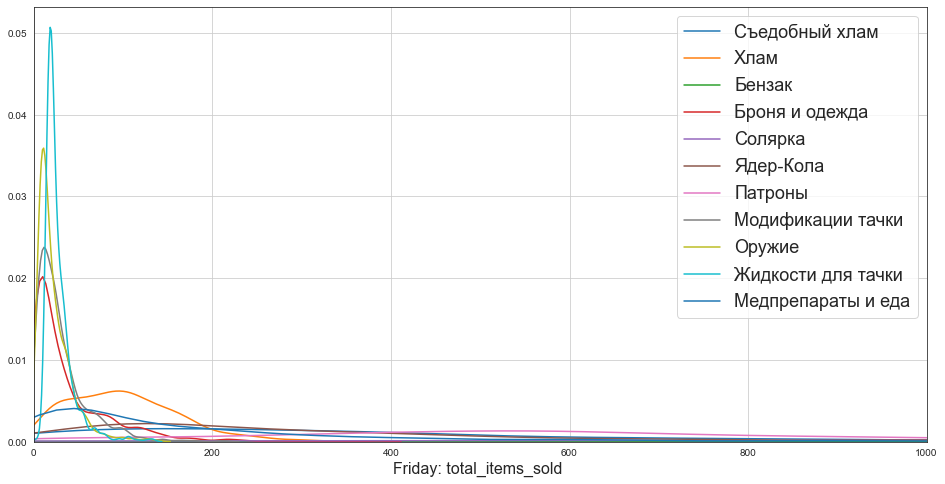

In [729]:
for day in pd.unique(sales['day_name']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for good in pd.unique(sales['goods_type']):
        sns.distplot(grouped_sales.query(f'(day_name=="{day}") & (goods_type=="{good}")')['total_items_sold'].values,
               label=good, ax=ax, bins='sturges',hist=False)
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_xlabel(f'{day}: total_items_sold ', fontsize=16)
    ax.set_xlim(0, 1000)
    plt.show()

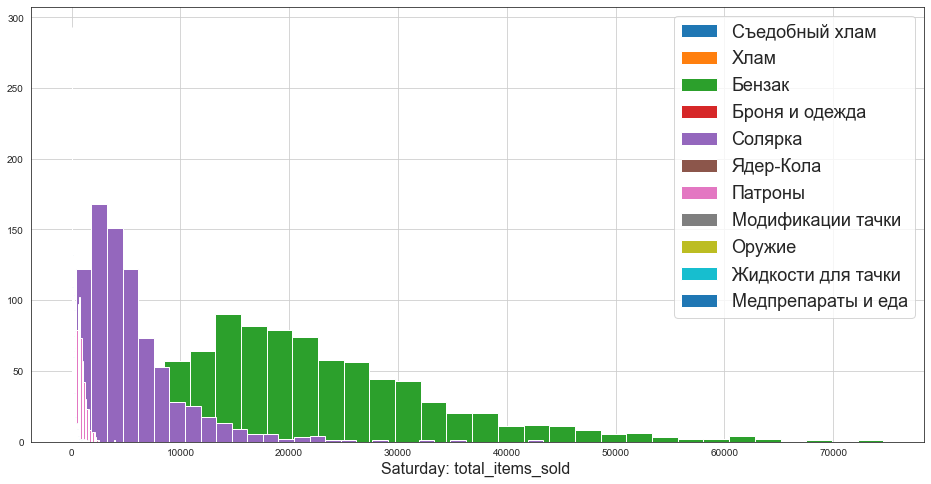

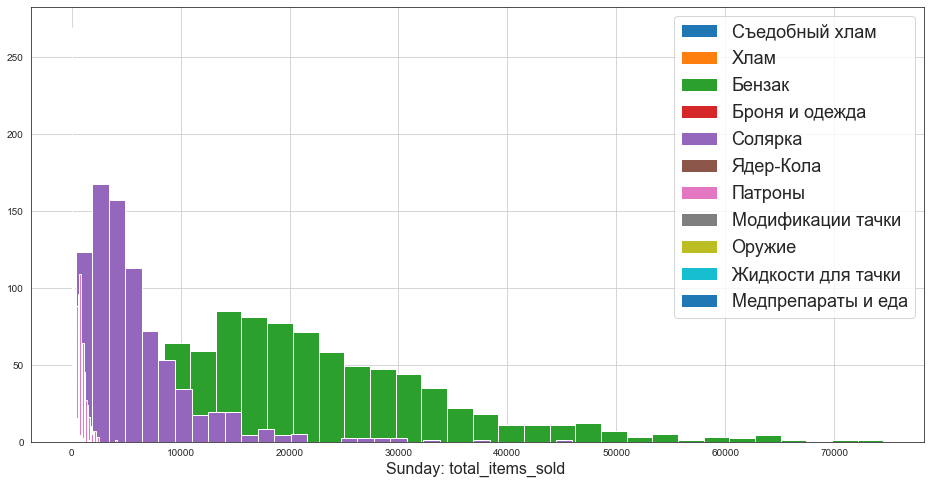

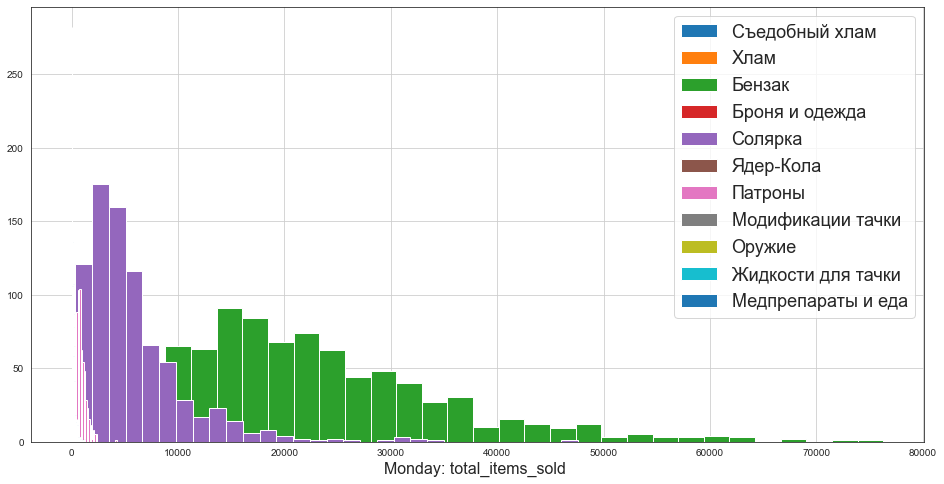

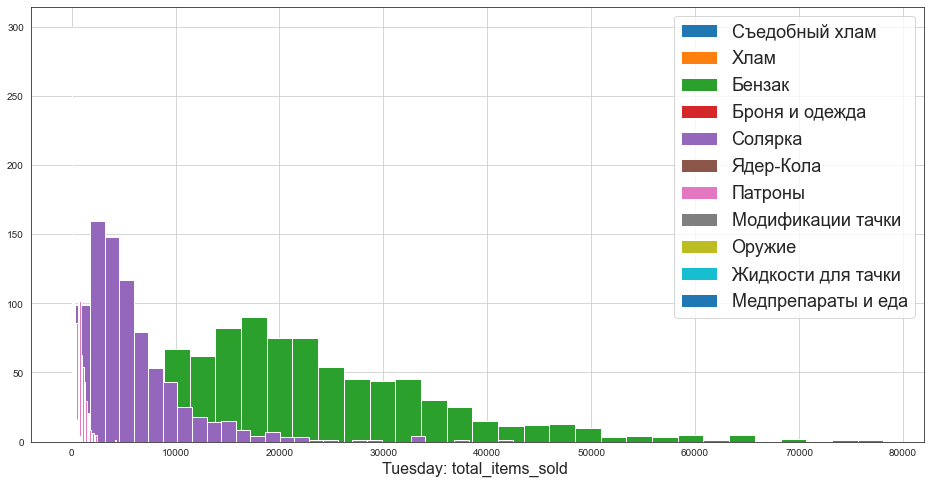

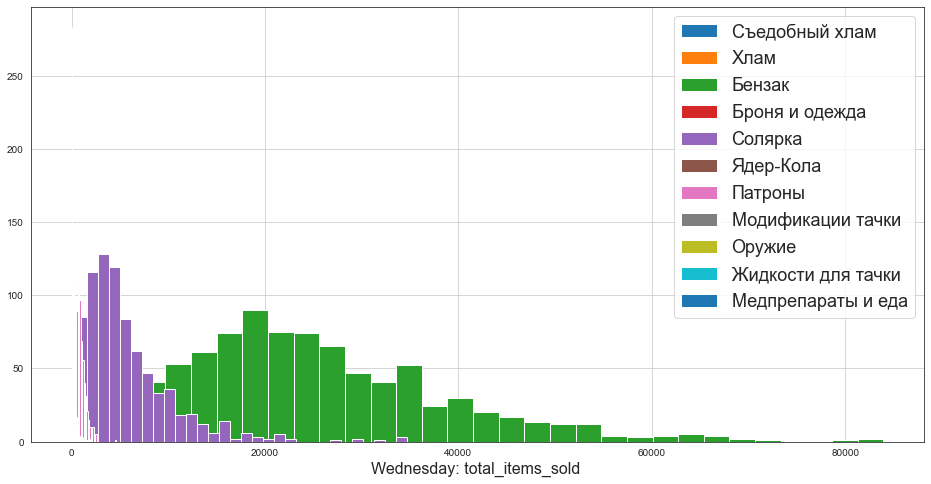

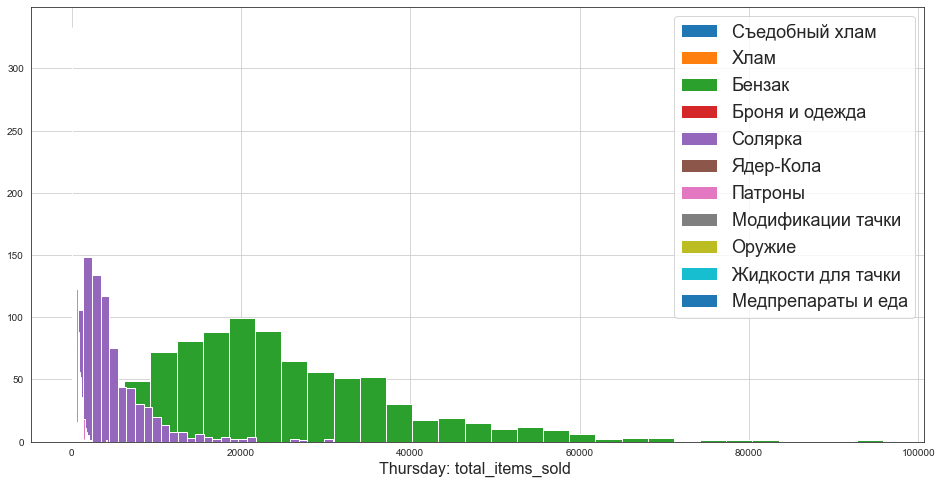

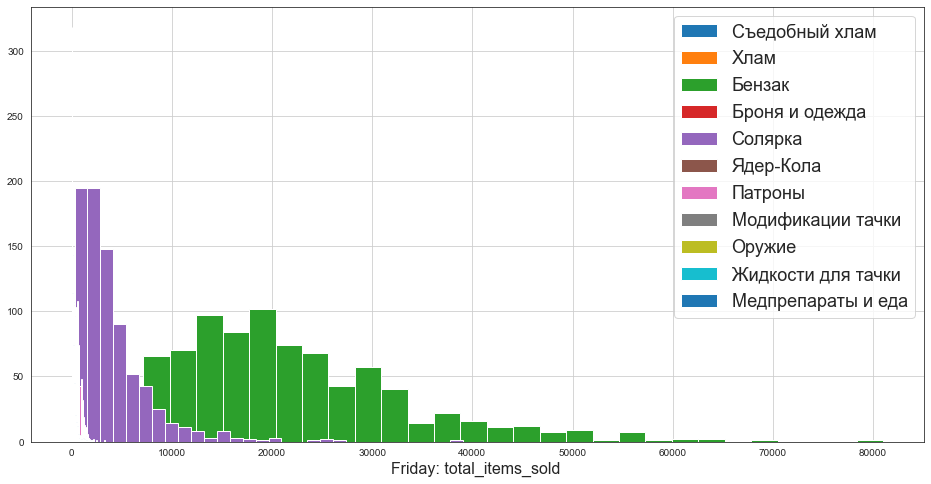

In [730]:
for day in pd.unique(sales['day_name']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for good in pd.unique(sales['goods_type']):
        ax.hist(grouped_sales.query(f'(day_name=="{day}") & (goods_type=="{good}")')['total_items_sold'].values,
               label=good,bins=30)
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_xlabel(f'{day}: total_items_sold ', fontsize=16)
    plt.show()

Почему мы взяли медиану? Это более робастная оценка, менее чувствительная к выбросам.

**Выводы**: видно, что распределение усреднённых продаж в разрезе по дням одинаковое для каждого дня недели, но разное для определённого вида продуктов. Мы видим, что `оружие`, `броня и одежда`, `жидкости для тачки`, `Модификации тачки имеют` явные столбики в районе нуля, распределение очень похоже на пуассона, математического ожидание пуассоновского распределения - $\lambda$ - следовательно медианное значение продаж для данных продуктов `approx 0`, а значит стоит рассматривать лишь остальные продукты, у которых среднее значение продаж не являетс нулевым. 

Так же можем видеть, что лишь `Солярка` и `Бензак` имеют значительные продажи.

#### 1.1.1.5 Суммарная продажа в разрере по `owner` и дням

In [731]:
gr_owner = sales.groupby(['shop_id', 'owner', 'day_name']).sum()
gr_owner

number_of_counters  total_items_sold     year  \
shop_id owner   day_name                                                   
0       Рейдеры Friday                    521         1516551.0   279032   
                Monday                    514         1597609.0   276886   
                Saturday                  525         1596342.0   281178   
                Sunday                    544         1648352.0   291909   
                Thursday                  528         1686819.0   283324   
...                                       ...               ...      ...   
844     Рейдеры Saturday                 9729         5096039.0  2095021   
                Sunday                   9779         5225327.0  2105767   
                Thursday                10191         5552002.0  2189474   
                Tuesday                  9630         5300336.0  2067124   
                Wednesday                9850         5895963.0  2114343   

                           month    day     doy  is_weekend  
shop_id owner   day_name                                     
0       Рейдеры Friday       736   2025   20367           0  
                Monday       721   2077   19991           0  
                Saturday     747   1986   20624         131  
                Sunday       741   2138   20449         136  
                Thursday     738   2072   20410           0  
...                          ...    ...     ...         ...  
844     Рейдеры Saturday    6714  15082  188877         976  
                Sunday      6655  15327  187159         981  
                Thursday    6991  15975  196813           0  
                Tuesday     6537  15422  184220           0  
                Wednesday   6728  15373  189304           0  

[7007 rows x 7 columns]

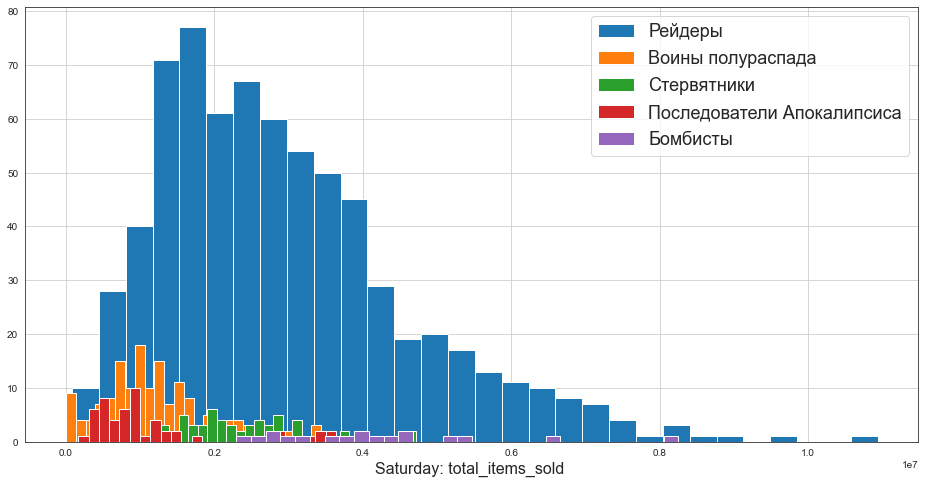

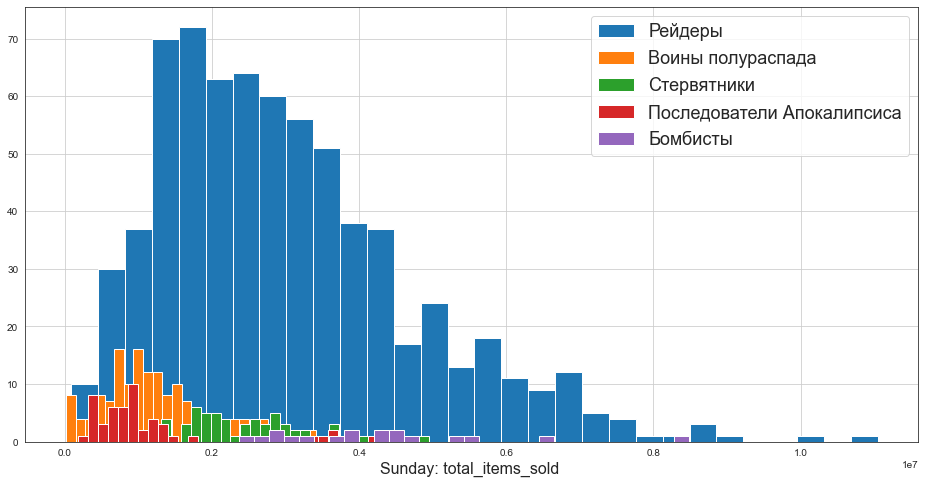

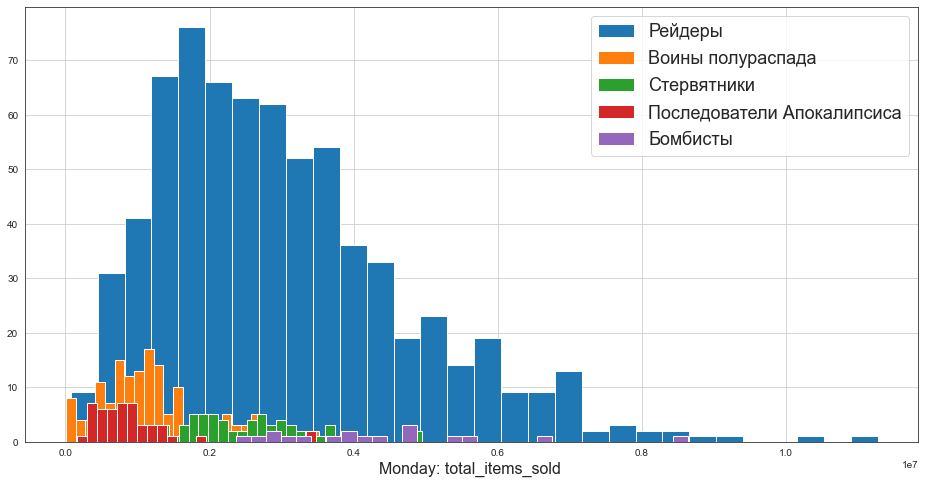

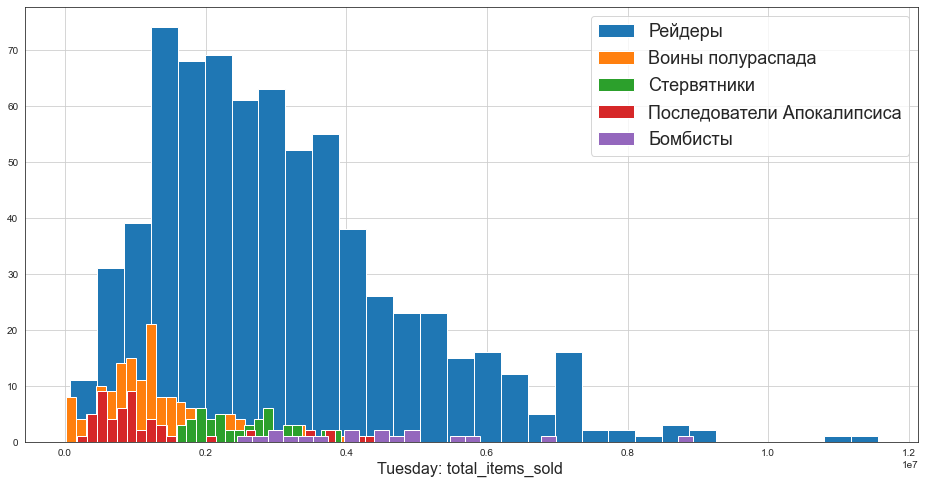

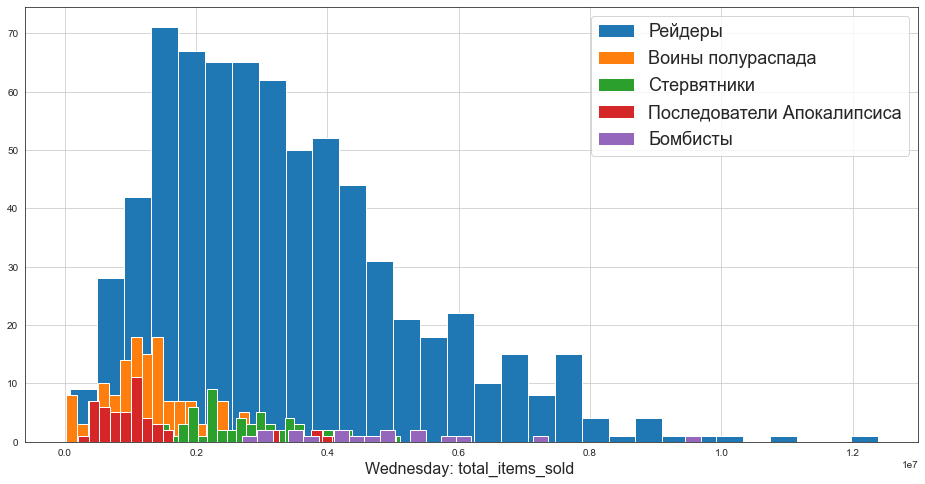

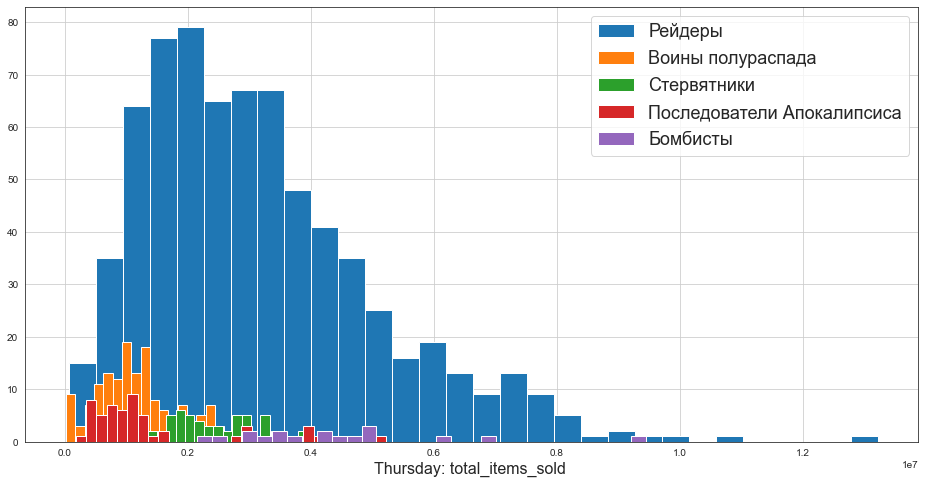

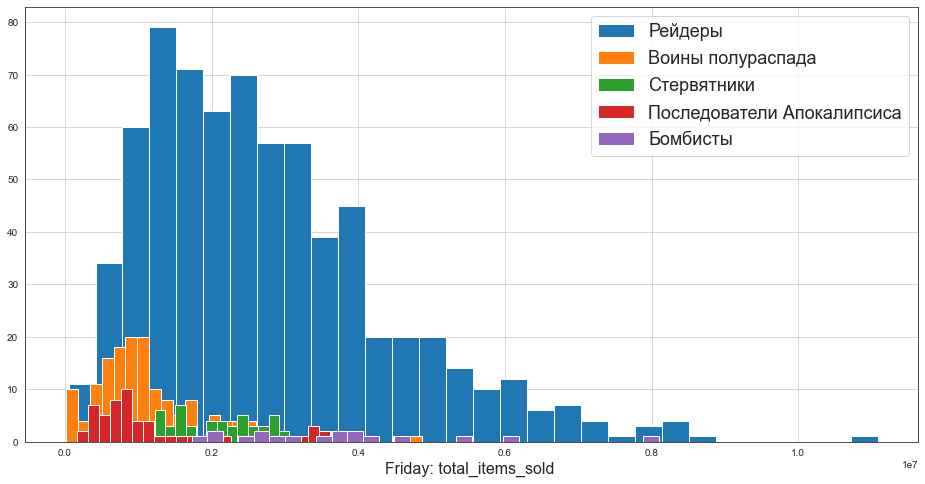

In [732]:
for day in pd.unique(sales['day_name']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for owner in pd.unique(sales['owner']):
        ax.hist(gr_owner.query(f'(day_name=="{day}") & (owner=="{owner}")')['total_items_sold'].values,
               label=owner,bins=30)
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_xlabel(f'{day}: total_items_sold ', fontsize=16)
    plt.show()

**Вывод**: основную вырочку получают магазины под руководством `Рейдеры`, затем `Воины полураспада`, затем идут остальные.

#### 1.1.1.6 Суммарные продажи по виду продукта в разрезе `owner`

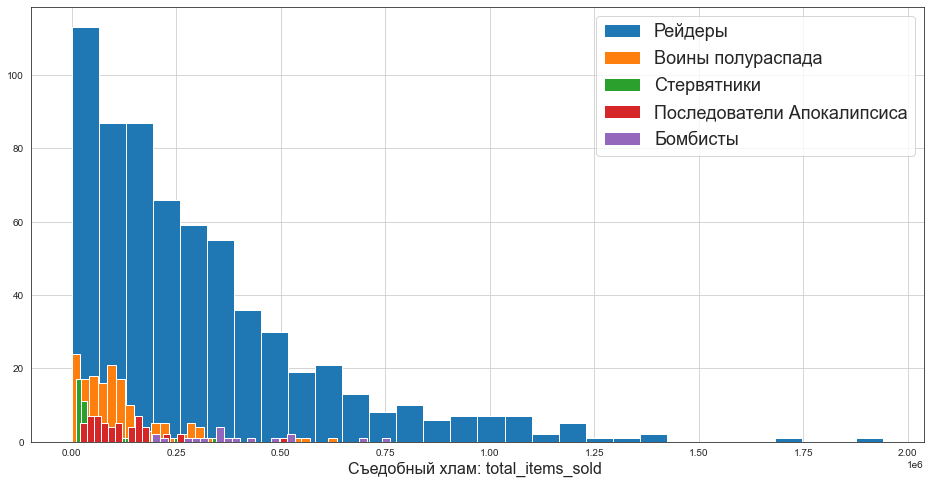

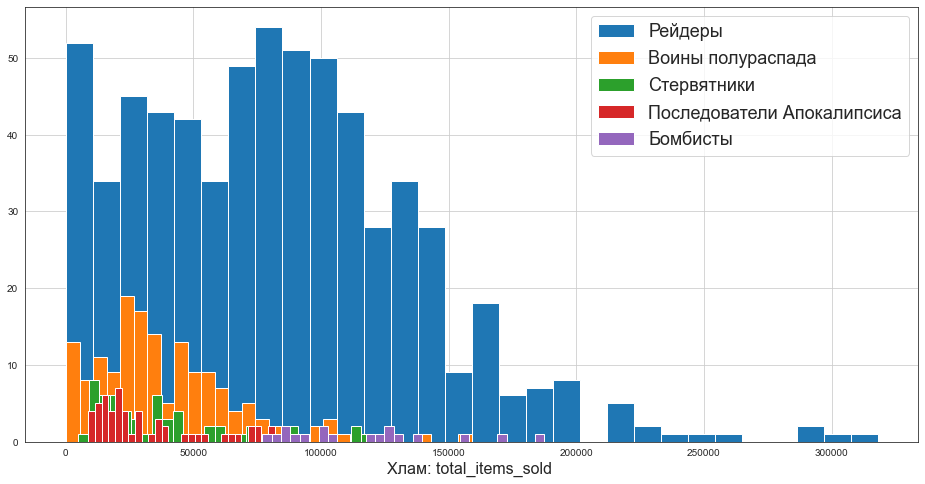

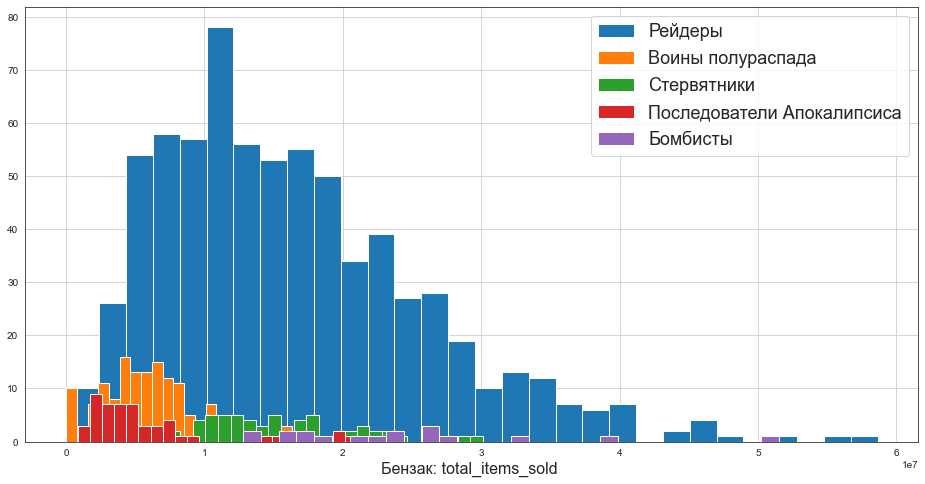

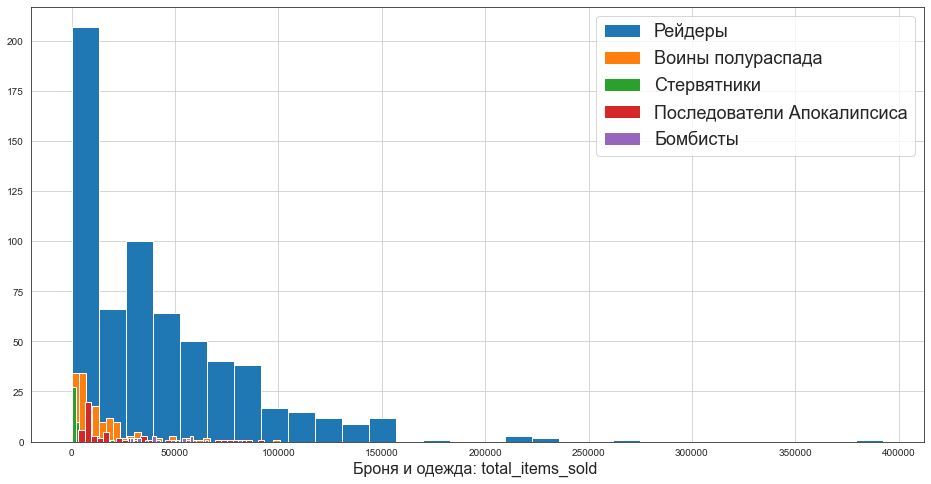

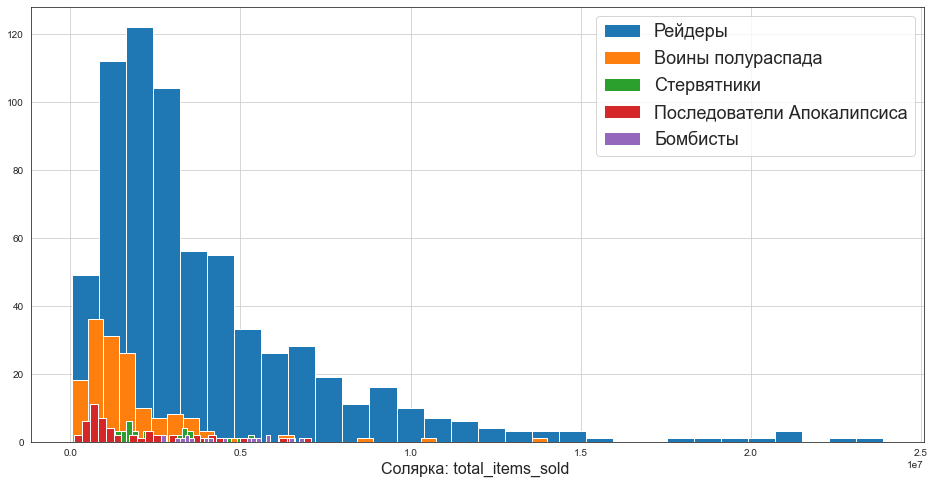

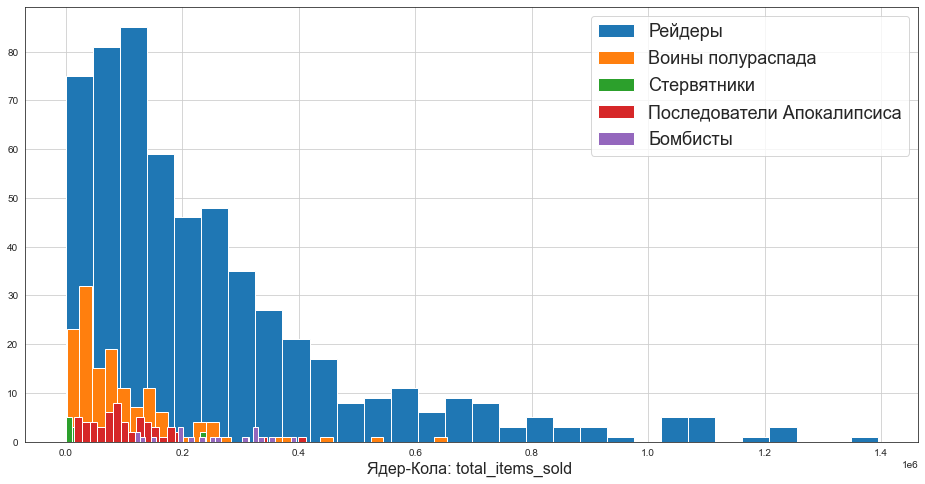

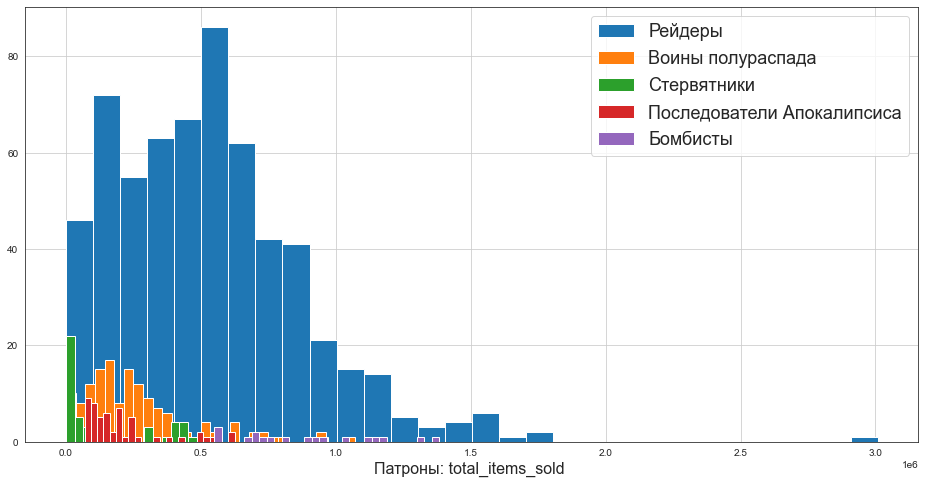

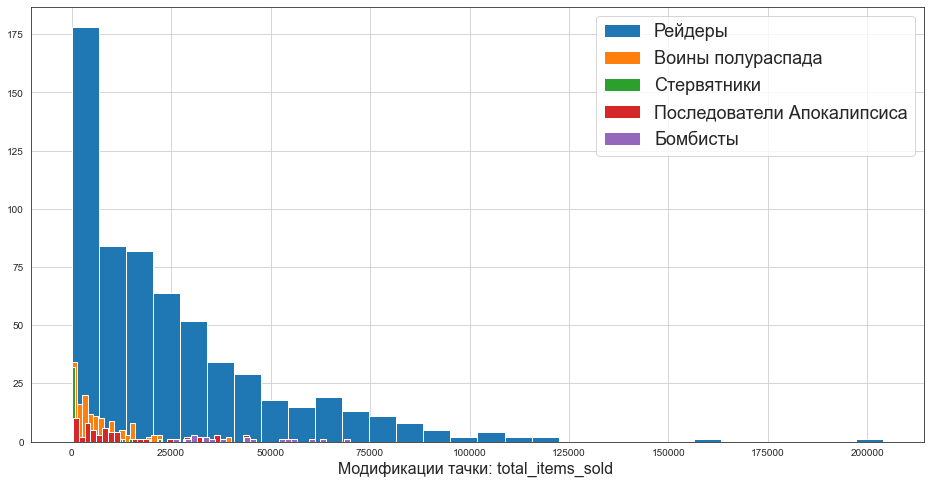

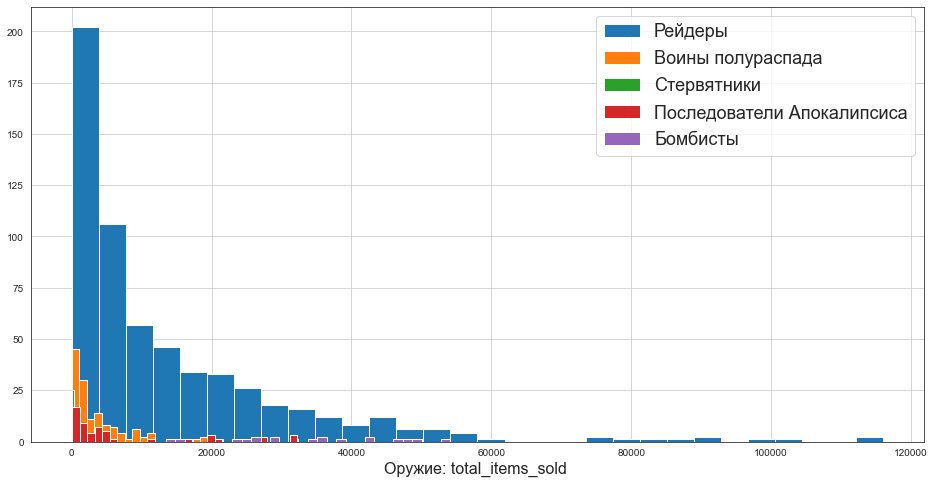

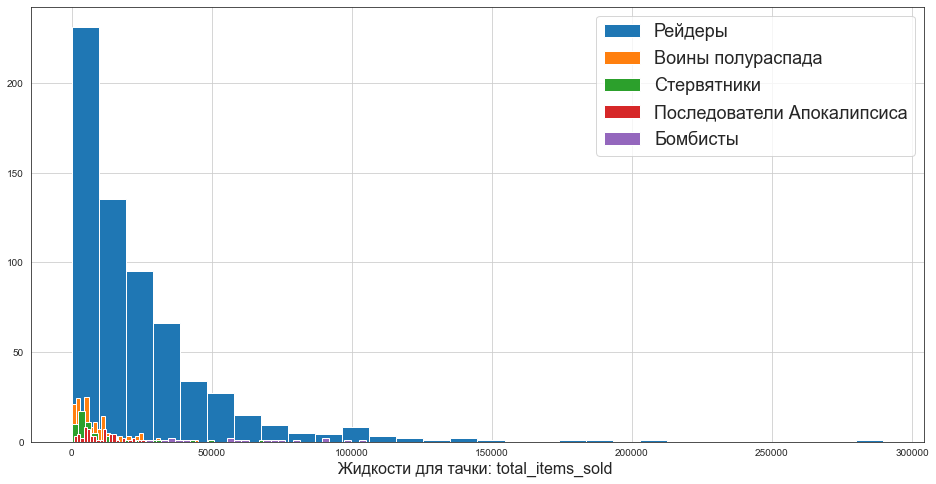

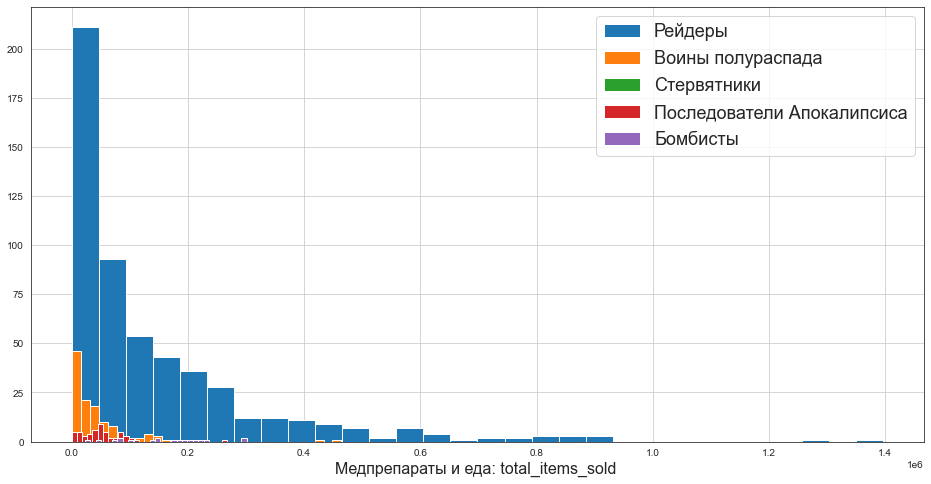

In [733]:
gr_owner = sales.groupby(['shop_id', 'owner', 'goods_type']).sum()

for good in pd.unique(sales['goods_type']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for owner in pd.unique(sales['owner']):
        ax.hist(gr_owner.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label=owner,bins=30)
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_xlabel(f'{good}: total_items_sold ', fontsize=16)
    plt.show()

**Вывод**: видно, что покупают `Патроны`, `Ядер-кола`, `Солярка`, `Бензак`, `Хлам`. У остальных гистограмм есть очень большие нулевые столбики.

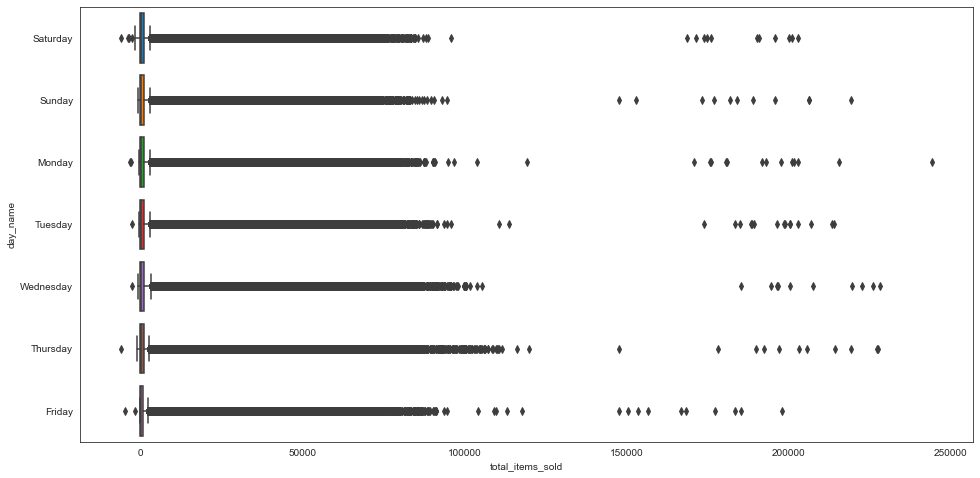

In [734]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(y='day_name', x='total_items_sold', data=sales, ax=ax)

**Вывод**: в среду покупают наибольшее количество, а в пятницу - наименьшее.

#### 1.1.1.7 Разница между максимальным и минимальным значением `number_of_counters`

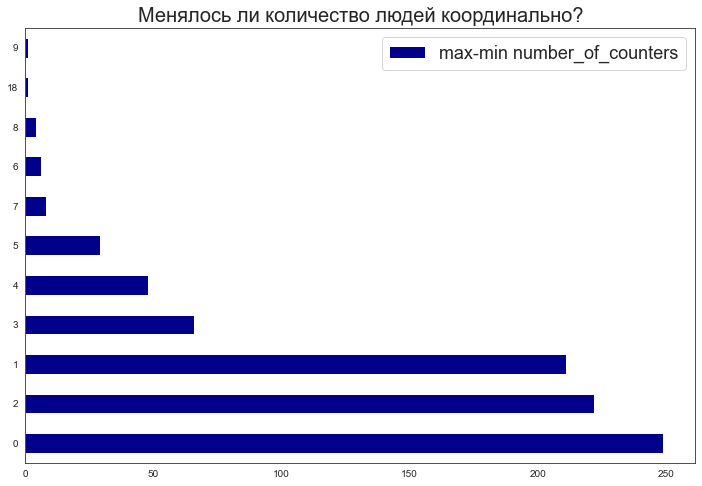

In [735]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pd.value_counts(
    (
        sales.groupby('shop_id')['number_of_counters'].max() - 
        sales.groupby('shop_id')['number_of_counters'].min()
    )
).plot.barh(color='darkblue', 
            ax=ax,
            label='max-min number_of_counters')
ax.legend(fontsize=18)
ax.set_title('Менялось ли количество людей координально?', fontsize=20)
plt.show()

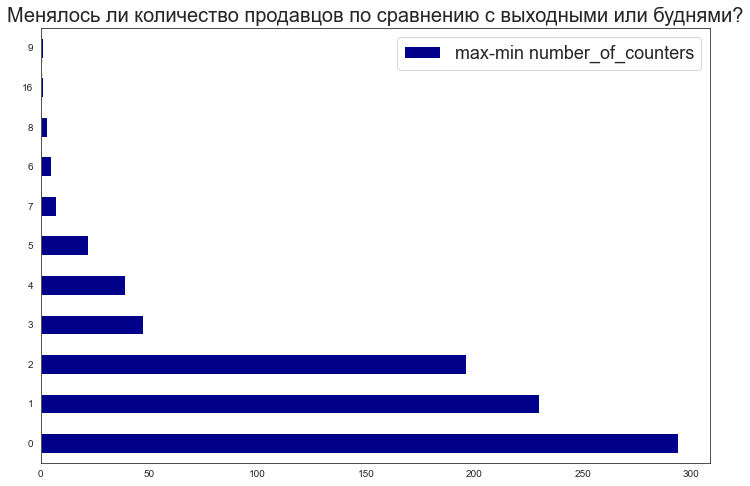

In [736]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pd.value_counts(
    (
        sales[sales.is_weekend==1].groupby('shop_id')['number_of_counters'].max() - 
        sales[sales.is_weekend==0].groupby('shop_id')['number_of_counters'].min()
    )
).plot.barh(color='darkblue', 
            ax=ax,
            label='max-min number_of_counters')
ax.legend(fontsize=18)
ax.set_title('Менялось ли количество продавцов по сравнению с выходными или буднями?', fontsize=20)
plt.show()

А теперь проверим в разрезе по команиям.

In [737]:
check_amount_of_counters = (
    sales.groupby(['shop_id', 'owner'])[['total_items_sold', 'number_of_counters']].max() -
    sales.groupby(['shop_id', 'owner'])[['total_items_sold', 'number_of_counters']].min()
)

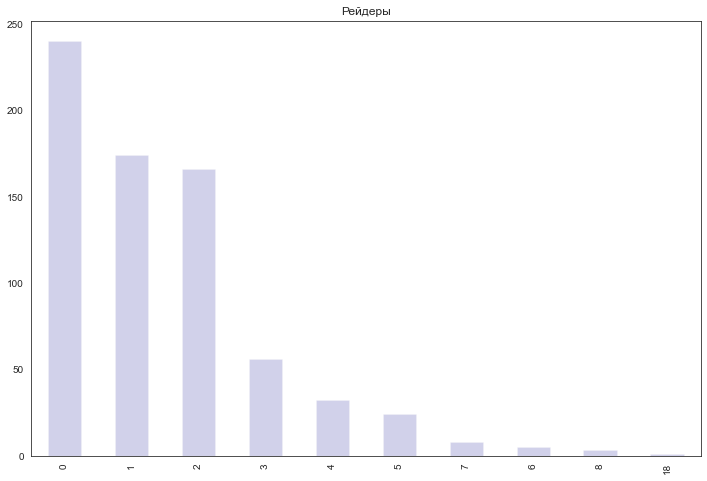

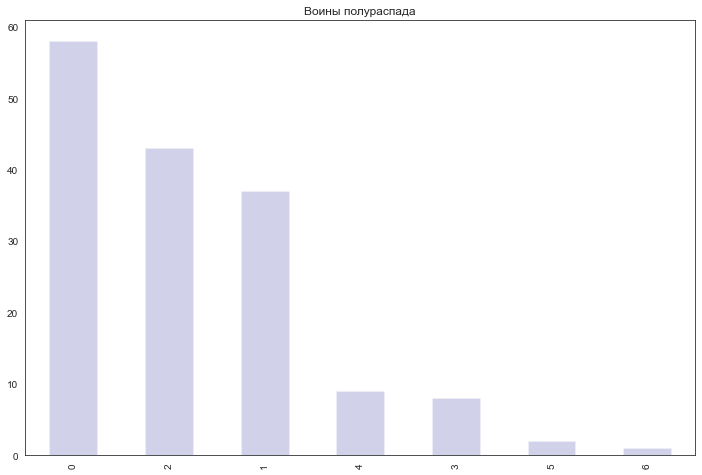

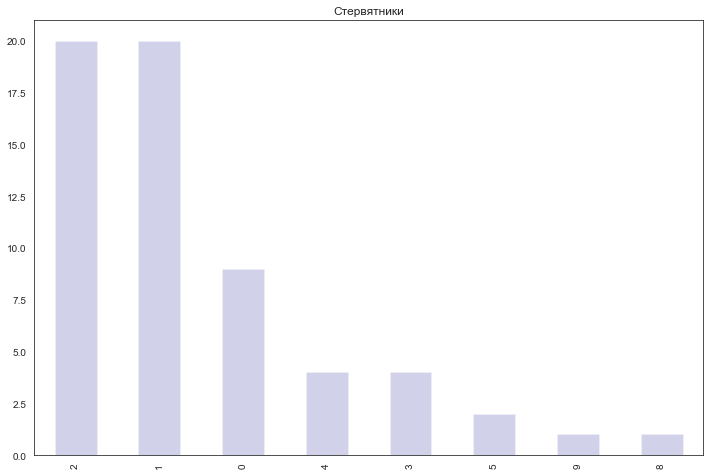

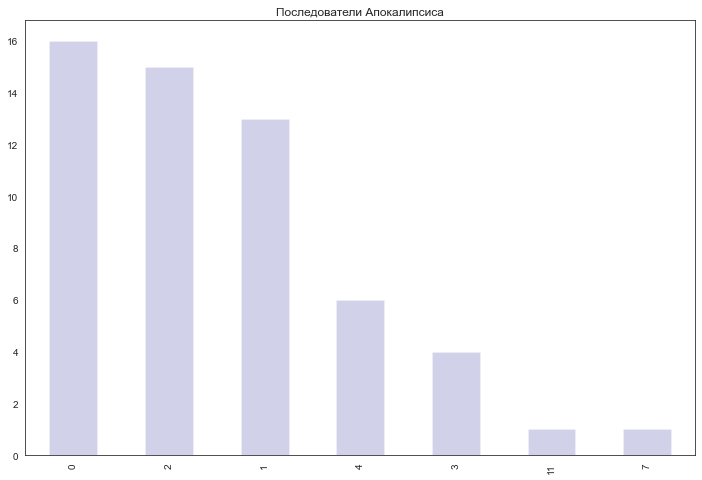

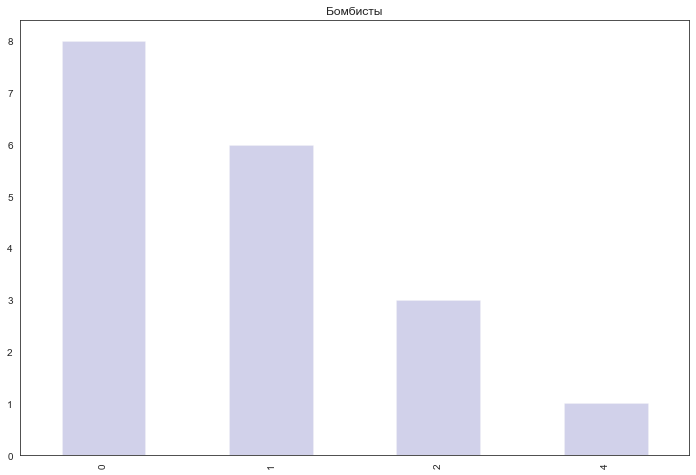

In [738]:
for owner in pd.unique(sales['owner']):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    pd.value_counts(check_amount_of_counters.query(f'owner=="{owner}"')['number_of_counters']).plot.bar(color='darkblue',alpha=.18)
    ax.set_title(owner)
    plt.show()

**Вывод**: чаще всего в каждом магазине работало одинаковое количество продавцов с добавлением одного в редких случаях. В выходные тоже не происходит резкого скачка продавцов.

#### 1.1.1.8 Распределение продаж на выходных

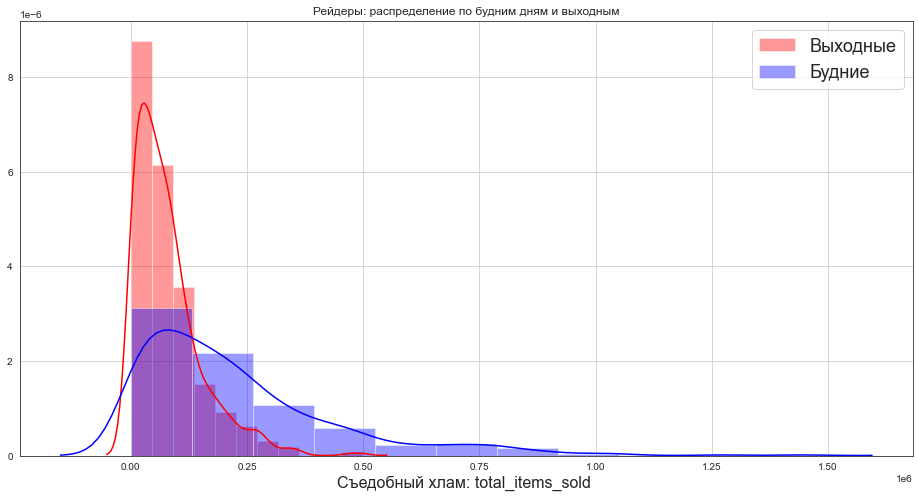

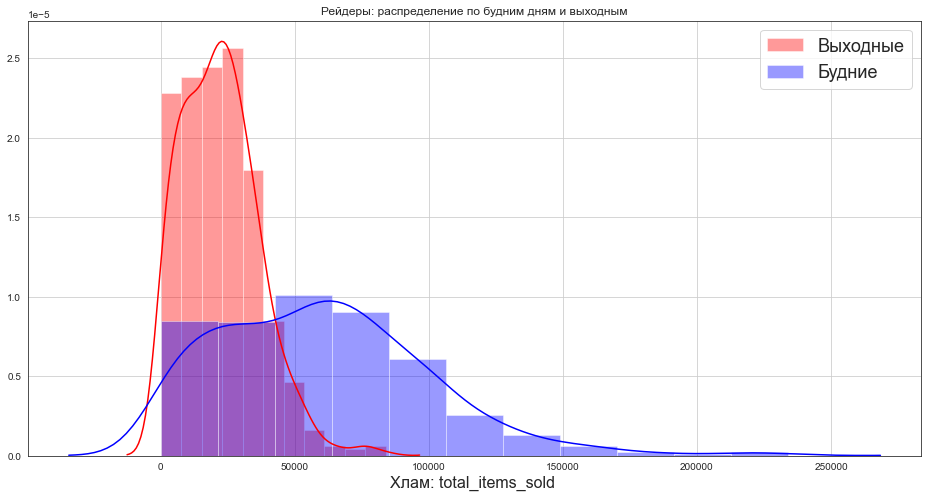

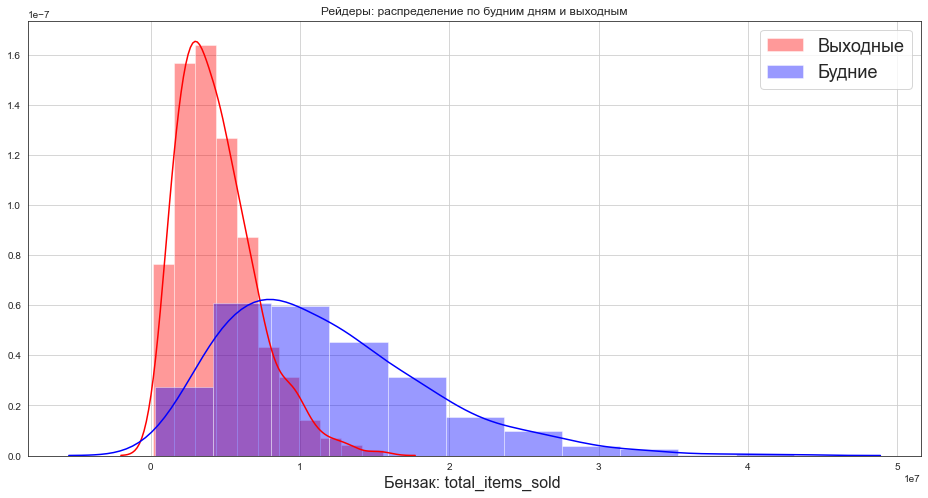

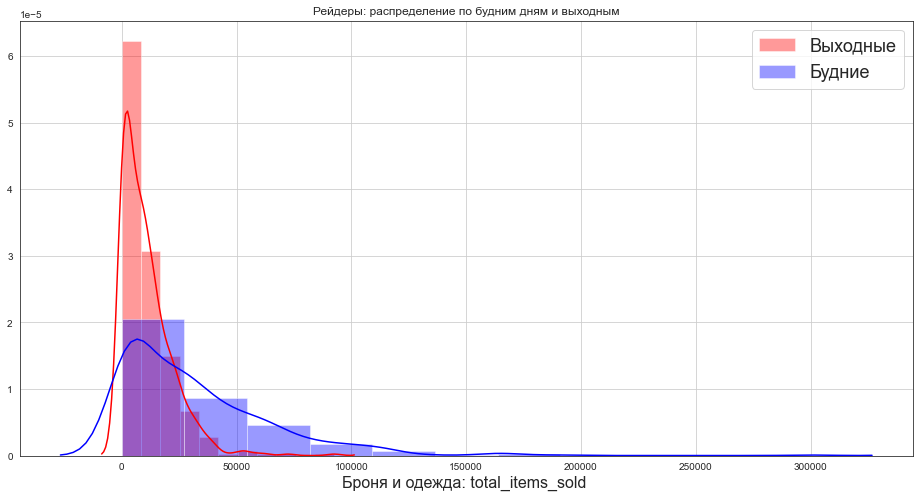

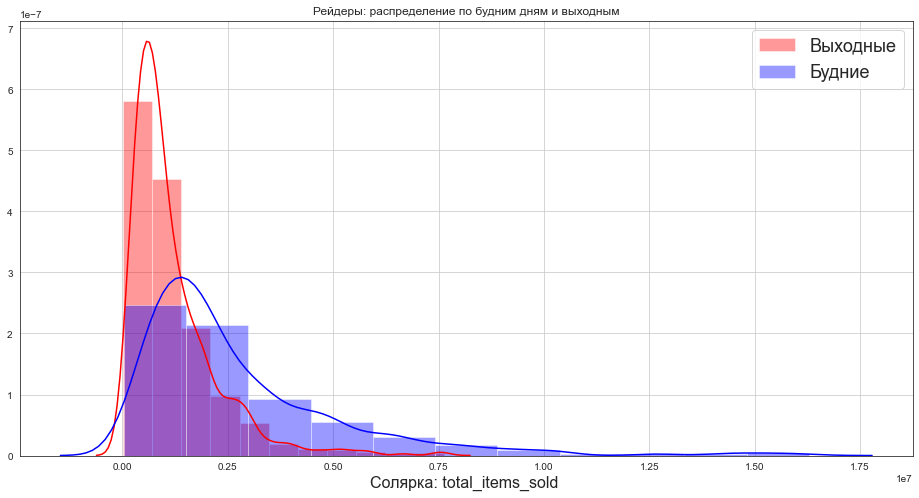

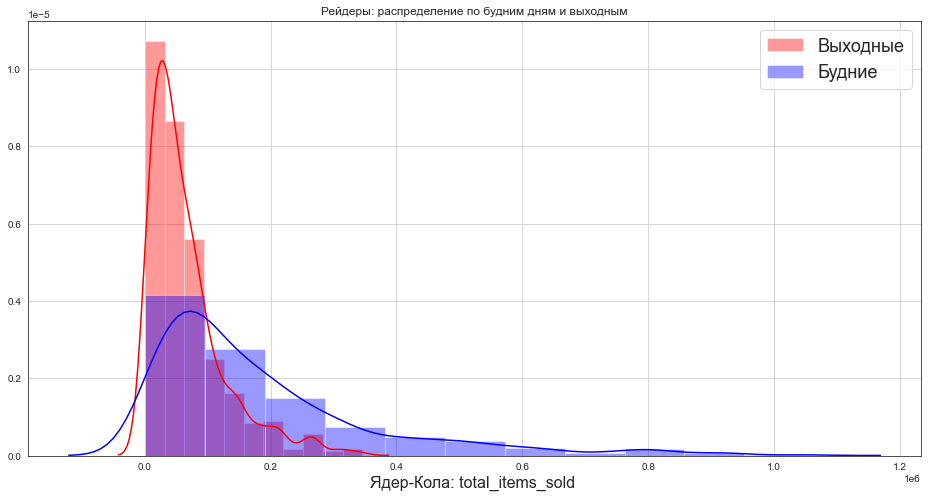

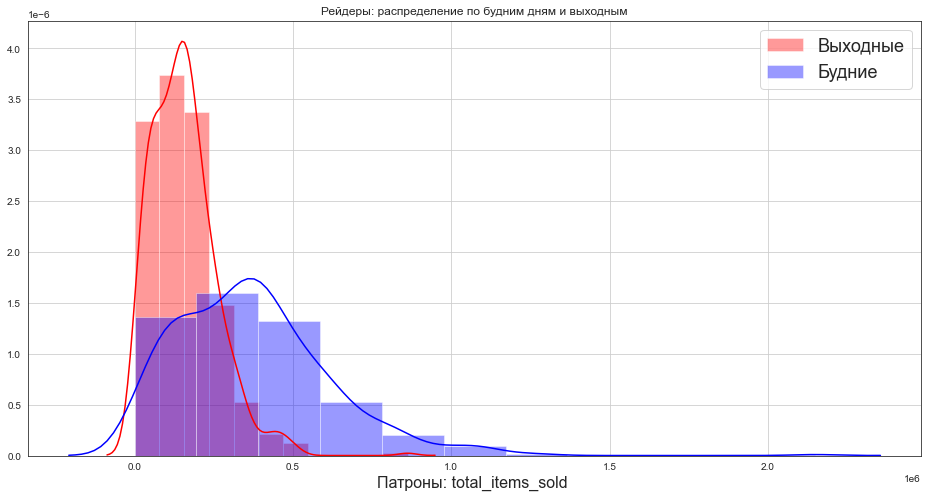

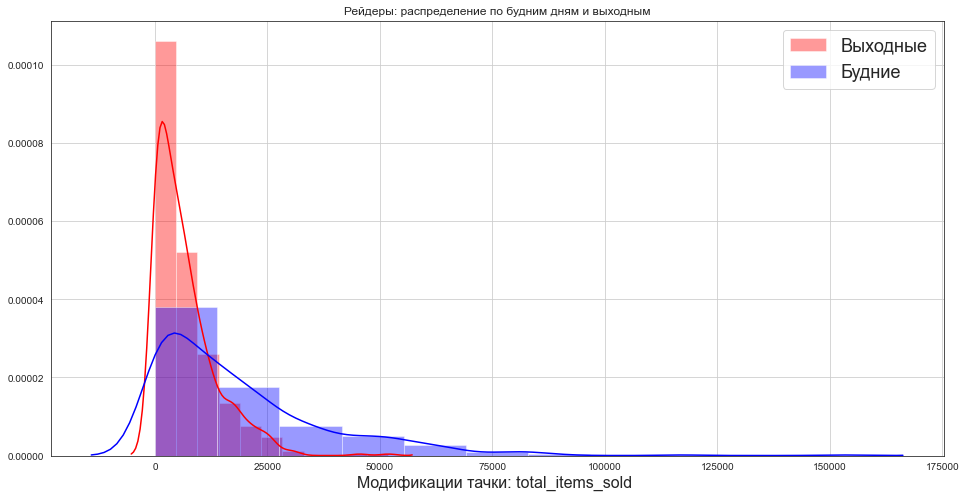

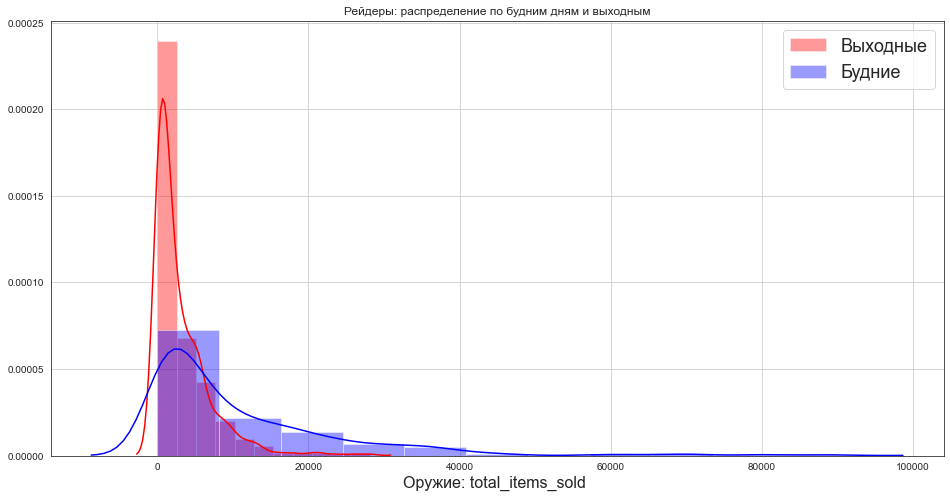

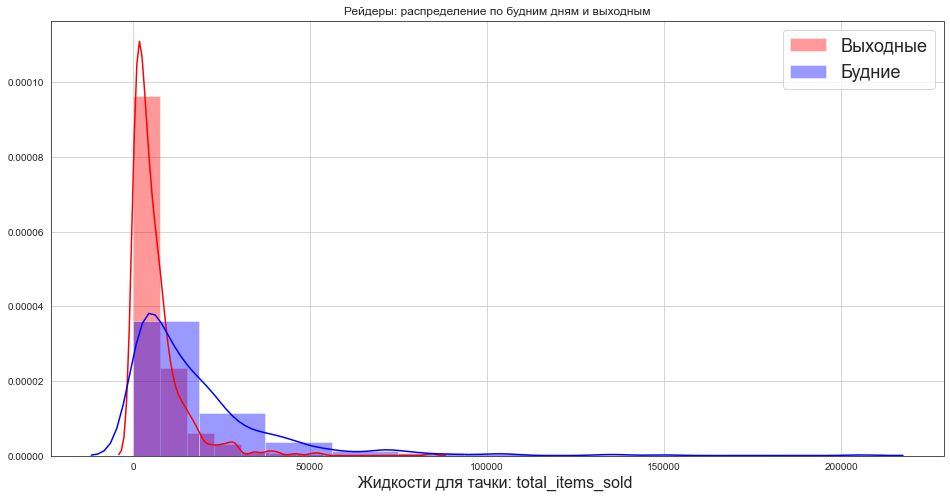

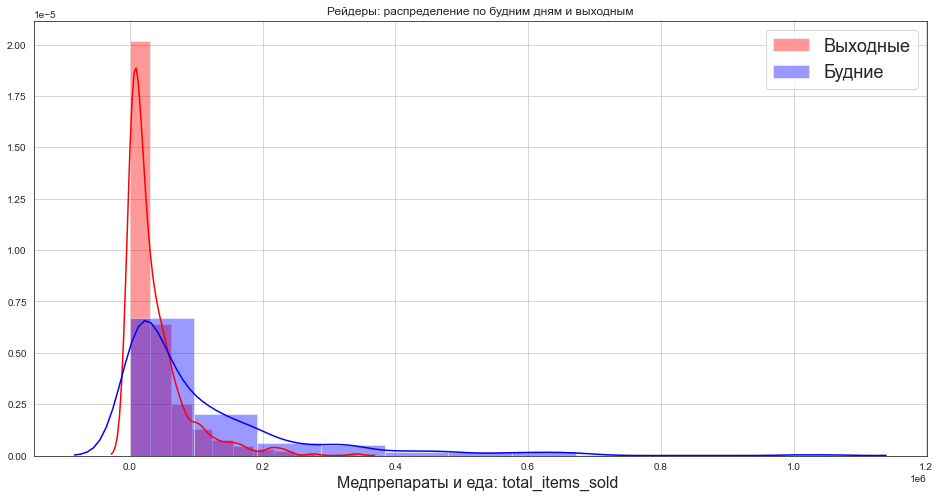

In [739]:
gr_own = sales[sales.is_weekend == 0].groupby(['shop_id', 'owner', 'goods_type']).sum()
gr_owner = sales[sales.is_weekend == 1].groupby(['shop_id', 'owner', 'goods_type']).sum()

for good in pd.unique(sales['goods_type']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for owner in ['Рейдеры']:
        sns.distplot(gr_owner.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Выходные',bins='sturges',ax=ax, color='red')
    for owner in ['Рейдеры']:
        sns.distplot(gr_own.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Будние',bins='sturges',ax=ax, color='blue')
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_title('Рейдеры: распределение по будним дням и выходным')
    ax.set_xlabel(f'{good}: total_items_sold ', fontsize=16)
    plt.show()

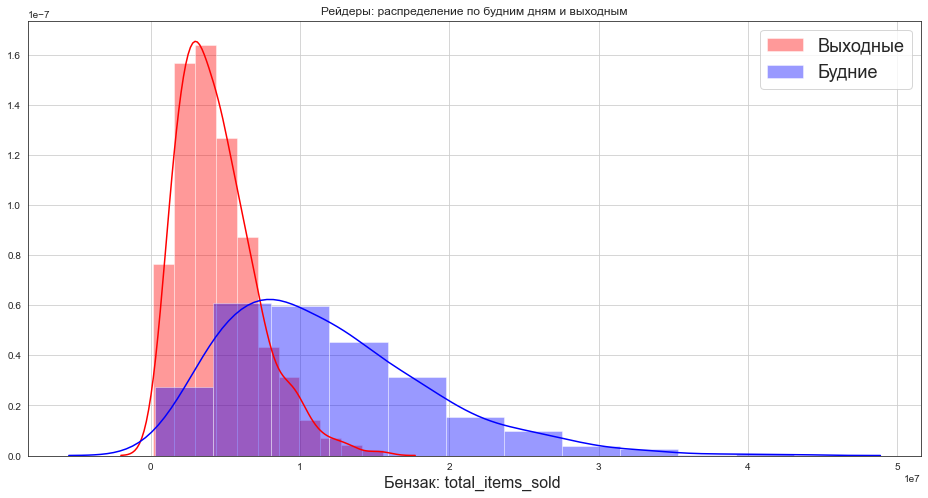

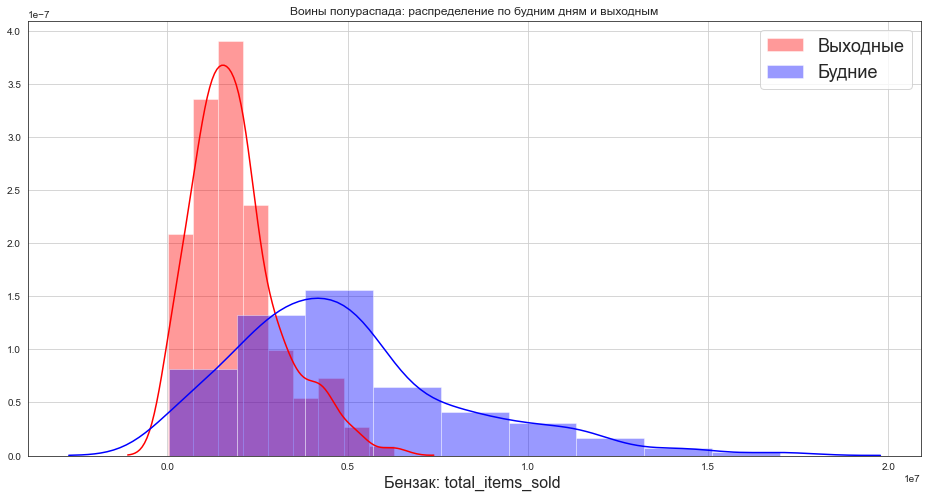

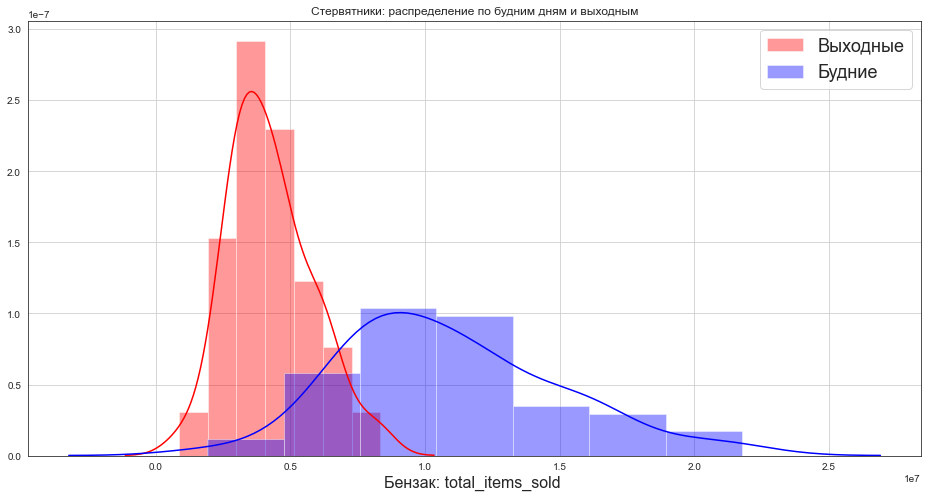

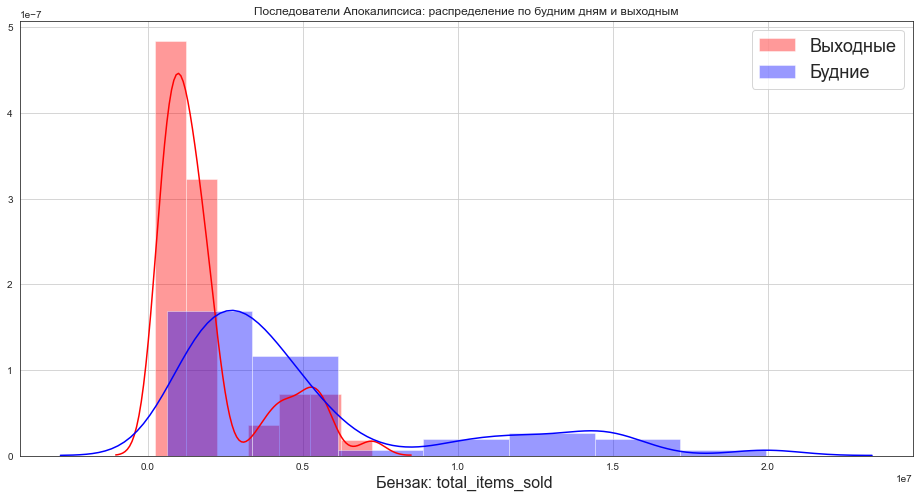

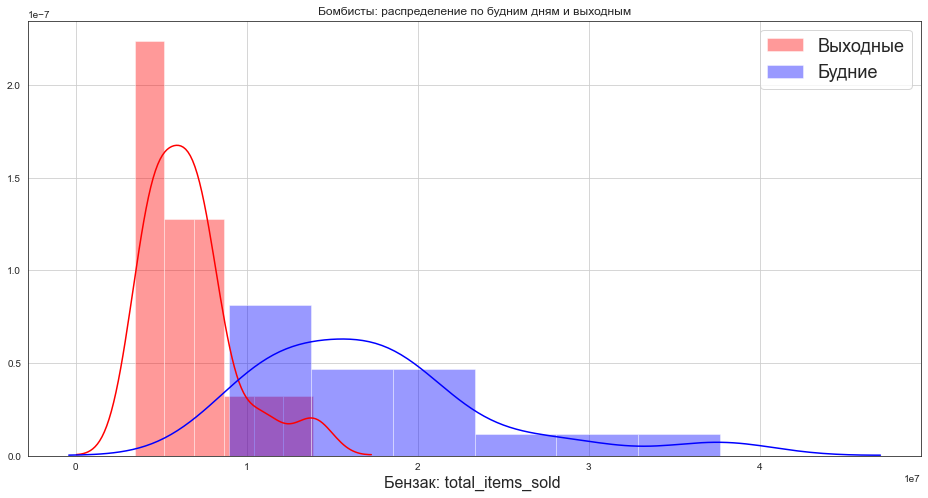

In [740]:
gr_own = sales[sales.is_weekend == 0].groupby(['shop_id', 'owner', 'goods_type']).sum()
gr_owner = sales[sales.is_weekend == 1].groupby(['shop_id', 'owner', 'goods_type']).sum()

for owner in pd.unique(sales['owner']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for good in [pd.unique(sales['goods_type'])[2]]:
        sns.distplot(gr_owner.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Выходные',bins='sturges',ax=ax, color='red')
        sns.distplot(gr_own.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Будние',bins='sturges',ax=ax, color='blue')
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_title(f'{owner}: распределение по будним дням и выходным')
    ax.set_xlabel(f'{good}: total_items_sold ', fontsize=16)
    plt.show()

**Вывод**: по выходным суммарное значение выручки больше, чем по будням, но как мы видим - с очень маленькими хвостами, а по будням - среднее значение выручки меньше, но хвосты тяжелые, поэтому логично предположить, что плотность распределения средних значений будет примерно одинаковая.

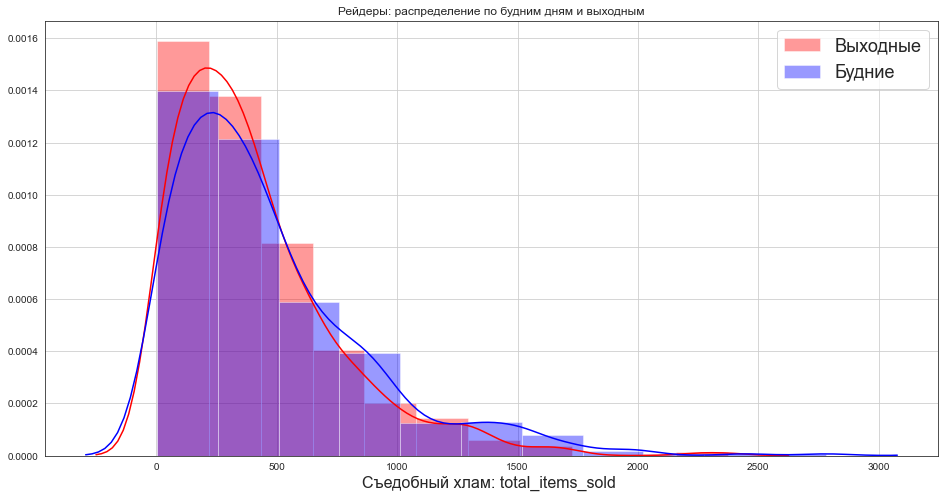

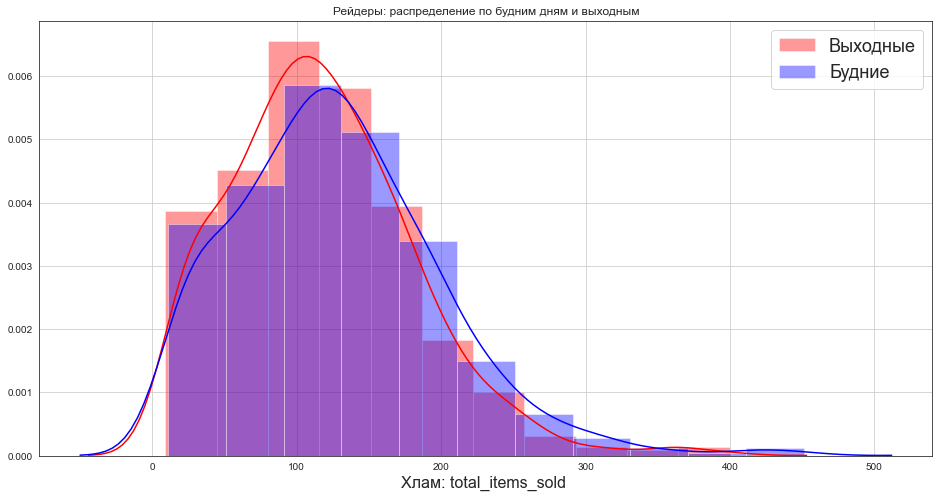

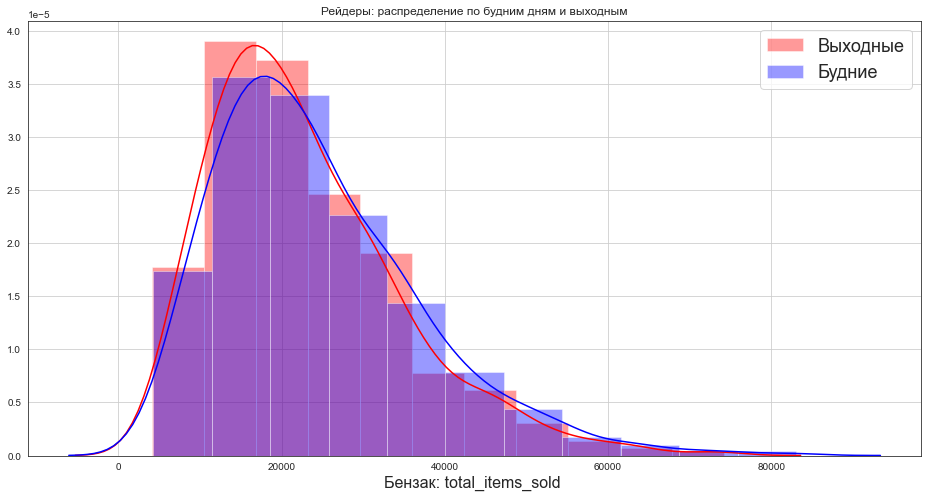

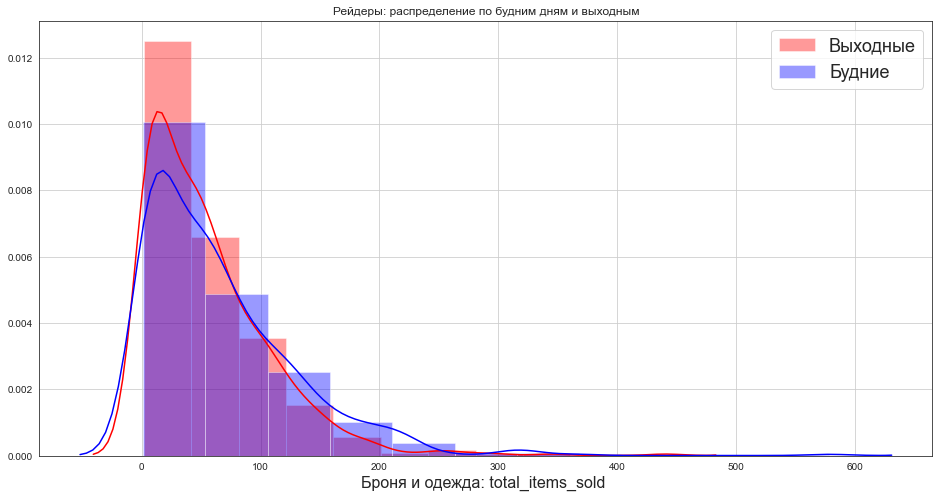

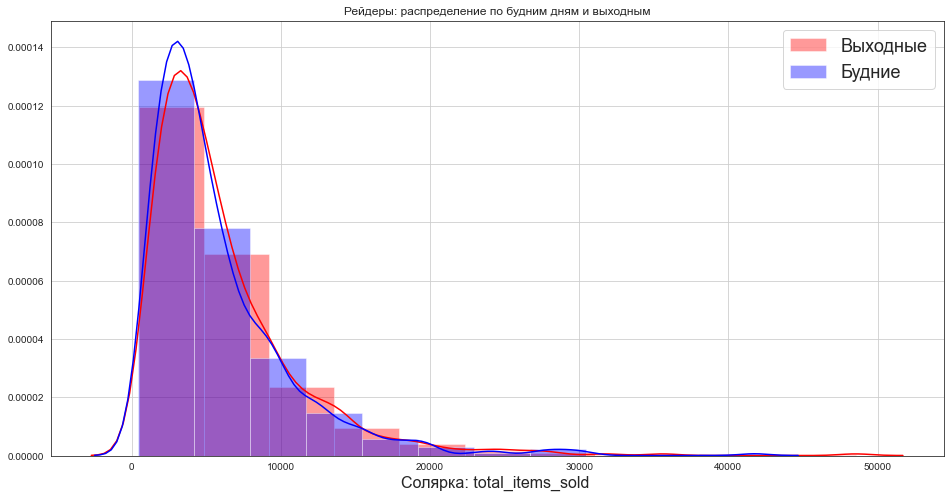

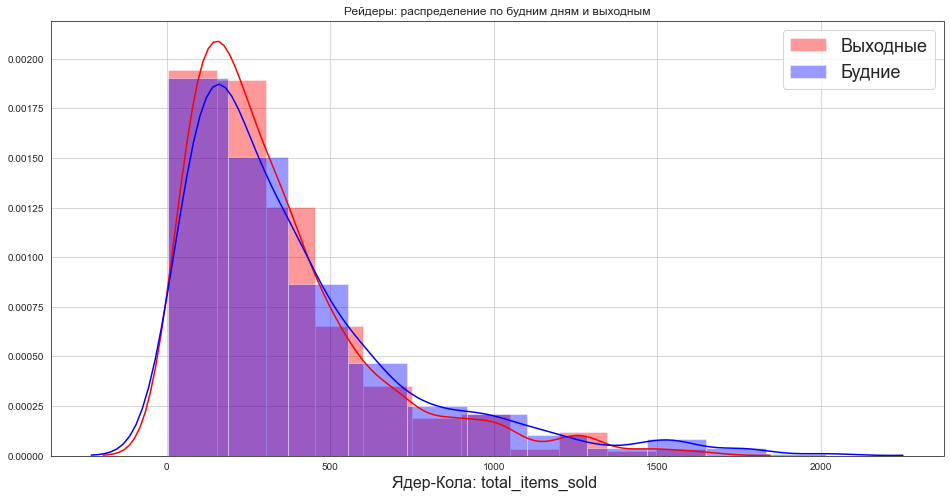

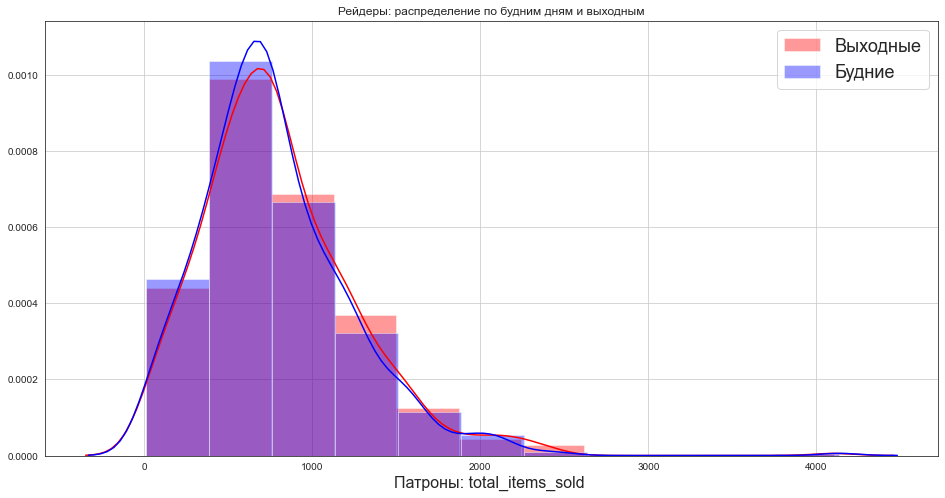

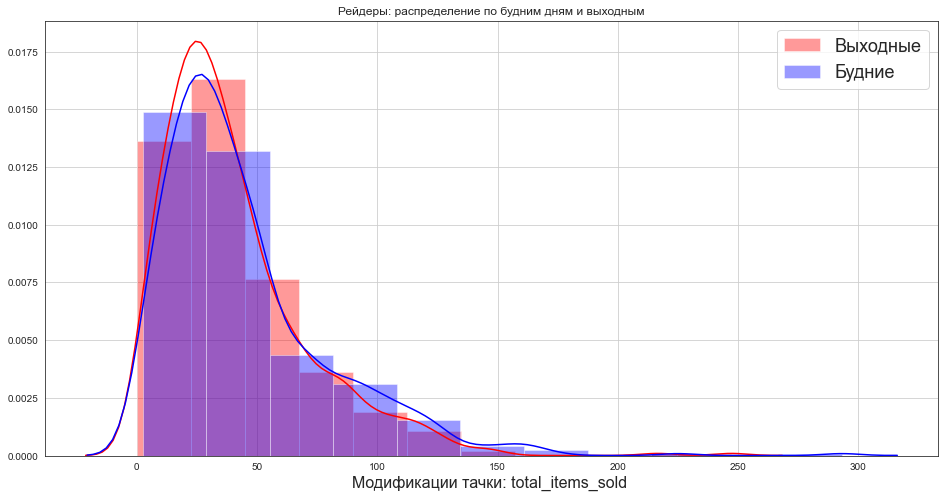

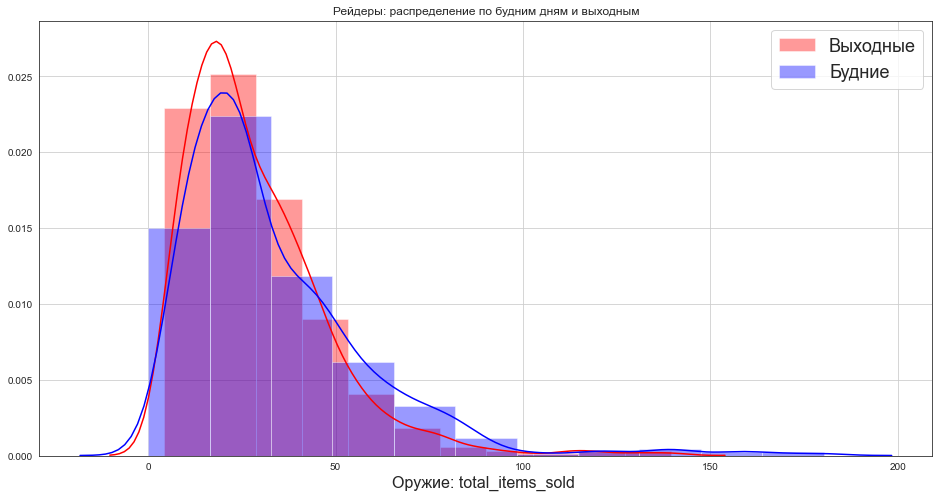

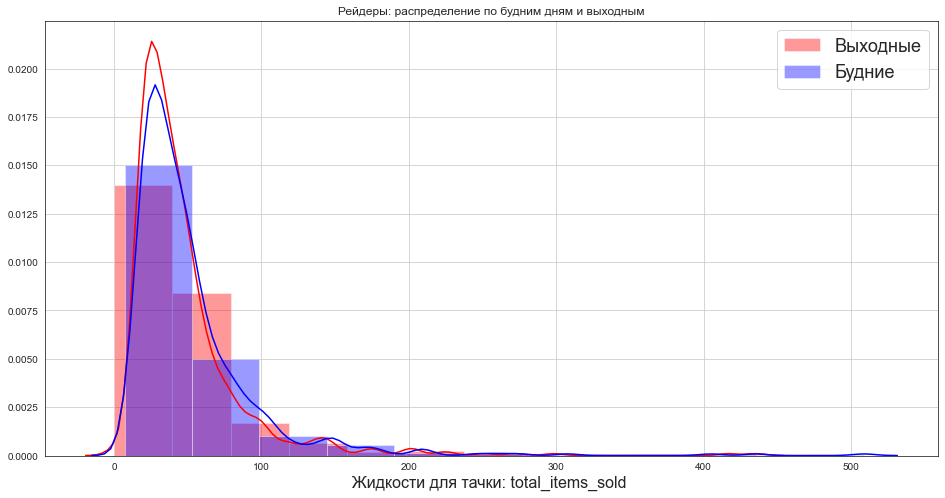

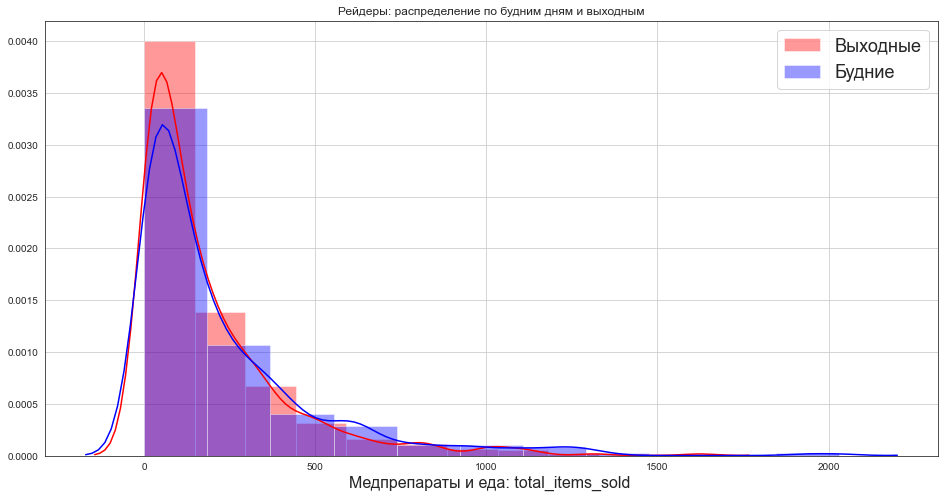

In [741]:
gr_own = sales[sales.is_weekend == 0].groupby(['shop_id', 'owner', 'goods_type']).mean()
gr_owner = sales[sales.is_weekend == 1].groupby(['shop_id', 'owner', 'goods_type']).mean()

for good in pd.unique(sales['goods_type']):
    alpha = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for owner in ['Рейдеры']:
        sns.distplot(gr_owner.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Выходные',bins='sturges',ax=ax, color='red')
    for owner in ['Рейдеры']:
        sns.distplot(gr_own.query(f'(goods_type=="{good}") & (owner=="{owner}")')['total_items_sold'].values,
               label='Будние',bins='sturges',ax=ax, color='blue')
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_title('Рейдеры: распределение по будним дням и выходным')
    ax.set_xlabel(f'{good}: total_items_sold ', fontsize=16)
    plt.show()

Как мы и предполагали.

### 1.1.2 Выводы по  `sales`

In [742]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,year,month,day,doy,day_name,month_name,is_weekend
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,2146,1,1,1,Saturday,January,1
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,2146,1,1,1,Saturday,January,1
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,2146,1,1,1,Saturday,January,1
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0,2146,1,1,1,Saturday,January,1
4,2146-01-01,1,Рейдеры,5,Хлам,9.0,2146,1,1,1,Saturday,January,1


In [743]:
sales.isna().sum()

date                  0
shop_id               0
owner                 0
number_of_counters    0
goods_type            0
total_items_sold      0
year                  0
month                 0
day                   0
doy                   0
day_name              0
month_name            0
is_weekend            0
dtype: int64

In [744]:
unique_owner_id = pd.unique(sales.owner)
owner_map = dict(zip(unique_owner_id, range(5)))
owner_map

{'Рейдеры': 0,
 'Воины полураспада': 1,
 'Стервятники': 2,
 'Последователи Апокалипсиса': 3,
 'Бомбисты': 4}

In [745]:
pd.value_counts(sales['owner'])

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

**Некая информация, о том, что мы получили**:

- `owner` - всего 5 владельцев магазинов - `Рейдеры`, `Воины полураспада`, `Стервятники`, `Последователи Апокалипсиса`, `Бомбисты`. Магазины под руководством `Рейдеры` получают наибольшую прибыль среди всех других.

- `number_of_counters` - из пункта `1.2.7` выяснено, что магазины не меняют количество своих продавцов $\pm 1$ за исключением каки-то единичных случаев, величина постоянная, выходные не влияют на количество продавцов.

- `good_types` - мы проанализировали и выяснили, что распределение общей выручки по дням недели и по месяцам одинаковое, если не разделять на продукты, но вот каждый продукт продаётся по своему, причём большинство продуктов продаются очень-очень плохо. Продукты, которые продаются хорошо - `Солярка`, `Бензак`. Также математическое ожидание продажи в выходные больше для любого продукта, чем в будние дни, но по будням дням распределение имеет тяжёлые хвосты, которые не стоит отбрасывать - по будням покупают реже, но покупка стоит дороже, а по выходным - больше, но дешевле.

- `total_items_sold` - просто проанализировали во всех возможных срезах - в среду покупают наибольшее количество продуктов, в пятницу - наименьшее.

**По поводу кластеризации**:

Мы увидели, что распределения везде одинаковые, за исключением распределения продаж определённых продуктов. Так как мы ищем те признаки, по которым можно сказать, что один магазин отличается от других магазинов, признак суммарной (или средней) выручки по продуктам, которые продаются (`Бензак` - самый предпочительный - имеет нормальное распределение (или близкое к нему), чудо просто), является явным признаком, по которым один отделяется от других. Так же в качестве признакак можно взять распределение продаж в среду и пятницу. В предположениях - возможно попробовать смотреть, есть ли разница в гистограммах среднихпродаж по будням и по выходным (предположение отвергнуто).

## 1.2 Данные по городам `cities`

In [746]:
cities

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь
5,Пасть,Свистящие Степи
6,Аэропорт,Скалистый Могильник
7,Равнина Маяка,Радиоактивная Пустошь
8,Дизельные Жилы,Свистящие Степи
9,Темница,Радиоактивная Пустошь


In [747]:
pd.unique(cities['location'])

array(['Скалистый Могильник', 'Свистящие Степи', 'Радиоактивная Пустошь'],
      dtype=object)

In [748]:
pd.value_counts(cities['location'])

Радиоактивная Пустошь    6
Свистящие Степи          5
Скалистый Могильник      4
Name: location, dtype: int64

**Выводы**: все города входят в 3 большие группы, равномерно распределённые, но больше информации пока не можем. В этом поможет таблица `shops`

## 1.3 Данные по характеристикам магазинов - `shops`

- `neighborhood` – в какой окрестности находится магазин
- `city` – в каком городе находится магазин 
- `year_opened` – в каком году открыт магазин
- `is_on_the_road` – находится ли магазин прямо у дороги
- `is_with_the_well` – есть ли у магазина колодец 
- `is_with_additional_services` – есть ли в магазине дополнительные сервисы
- `shop_type` – тип магазина

Данный источник является менее точным, чем данные о продажах, так как ведётся и обновляется вручную.

### 1.3.1 `shops` analysis

А вот на последнее предложение в предыдущем подпункте обратим внимание - это означает, что данные могут быть пропущны или неправильно истолкованы в больших количествах.

План следующий - сначала приведём в порядок данные в данной таблице, а затем соединим с остальными таблицами.

In [749]:
# найти все признаки, в которых первое значение - строка 
def find_cat(data, num_uniq=4):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique()<=num_uniq):
            s += ' мало уникальных'
        if (s!=name):
            print (s)
            
find_cat(shops)

neighborhood строка,
city строка,
is_on_the_road строка, мало уникальных
is_with_the_well строка, мало уникальных
is_with_additional_services строка, мало уникальных
shop_type строка, мало уникальных


In [750]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


Отсортируем по `shop_id`, для начала

In [751]:
shops = (
    shops.sort_values(by='shop_id', 
                      ignore_index=True)
)

In [752]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
1,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
2,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
3,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
4,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


In [753]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   shop_id                      845 non-null    int32 
 1   neighborhood                 845 non-null    object
 2   city                         788 non-null    object
 3   year_opened                  845 non-null    int32 
 4   is_on_the_road               838 non-null    object
 5   is_with_the_well             785 non-null    object
 6   is_with_additional_services  784 non-null    object
 7   shop_type                    713 non-null    object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


1. Будем последовательно анализировать столбцы. Начнём с `neighborhood`. Есть какое-то строковое описание местоположения и лично мне кажется, что необходимо определить, насколько местоположение данное выгодное для города и только заменять числовыми характеристиками. Это мы сможем сделать, соеднив первую и вторую таблицу по колонке `shop_id` и высчитать, какое местоположение является наиболее выгодным (по суммарной выручке, например). Поэтому, пока что оставим данный столбец.

In [754]:
unq_neighborhood = pd.unique(shops['neighborhood'])
unq_neighborhood

array(['В центре', 'Промзона', 'У ночлега', 'У воды', 'На отшибе',
       'У тоннеля', 'С краю'], dtype=object)

2. Теперь проанализируем столбец `city`

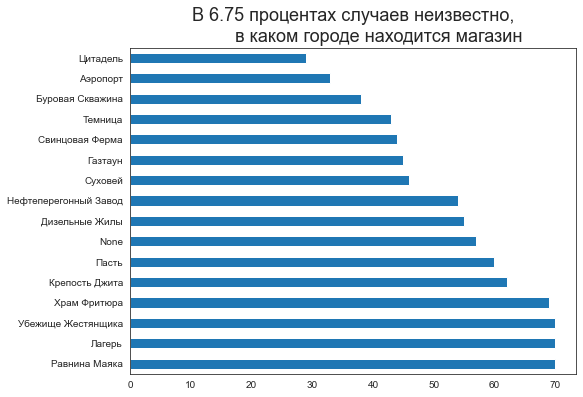

In [755]:
un_city = (
    pd.value_counts(shops['city'].astype(str))
)
(
    un_city
    .plot.barh(figsize=(8, 6))
)
plt.title(f'''В {(un_city / un_city.sum())["None"] * 100:.3} процентах случаев неизвестно,
          в каком городе находится магазин''',
         fontsize=18)
plt.show()

**Причина плохой кластеризации по городам**: видим, что в практические `7` процентах случаев неизвестно (`None`), в каком городе находится магазин. В этом и есть причина, по которому кластеризация по городам не является оптимальным - во-первых, у нас много городов и большое количество кластеров.. весьма неинтерпретируемо, во-вторых у нас весьма велика вероятность (она сравнима с вероятностями других городов) того, что какой-то магазин мы просто не сможем обнаружить в этом столбце и примерно 7 столбцов наблюдений мы просто выкидываем. А вдруг данный `shop_id` принадлежит `Рейдерам` и мы потеряем огромное количество прибыли из рассмотрения (такое же возможно). Поэтому, кластеризация по городам - не очень хорошая идея, постараемся придумать получше, получается.

Что сделаем с пропущенными значениями городов? Думаю, что столбец нам этот не очень понадобится, раз мы не будем проводить кластеризацию по городам, поэтому просто переведём в строчный тип.

In [756]:
shops['city'] = shops['city'].astype(str)

3. Рассмотрим столбец `year_opened` - открытие магазин - насколько новый магазин.

In [757]:
pd.unique(shops['year_opened'])

array([2136, 2115, 2092, 2108, 2116, 2139, 2132, 2118, 2119, 2140, 2138,
       2142, 2097, 2099, 2128, 2103, 2104, 2106, 2101, 2096, 2098, 2102,
       2127, 2137, 2124, 2125, 2109, 2126, 2105, 2094, 2091, 2135, 2090,
       2131, 2085, 2113, 2114, 2100, 2093, 2112, 2123, 2133, 2107, 2130,
       2134, 2141,   -1, 2129, 2143, 2117, 2074, 2089, 2086, 2111, 2095,
       2110])

Всё бы ничего, но встречается `-1` - пропущенное значение, неизвестность. Причём, если посмотреть на частоты, то увидим следующее:

In [758]:
pd.value_counts(shops['year_opened']).head(10)

 2139    94
-1       63
 2132    55
 2141    52
 2142    51
 2137    41
 2140    36
 2138    32
 2130    27
 2131    27
Name: year_opened, dtype: int64

Очень часто неизвестно, когда магазин был открыт. Давайте просто посмотрим на информацию о данным городам.

In [759]:
pd.value_counts(shops[shops['year_opened']==-1]['city'])

Пасть               24
Равнина Маяка        6
Темница              5
Храм Фритюра         5
Буровая Скважина     5
Крепость Джита       4
Газтаун              4
Лагерь               3
Аэропорт             3
Цитадель             2
Суховей              1
Дизельные Жилы       1
Name: city, dtype: int64

In [76]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
1,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
2,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
3,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
4,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


Было предложено удалить данный признак из рассмотрения.

4. Признак `is_on_the_road` - находится ли магазин прямо у дороги.

In [760]:
print(pd.unique(shops['is_on_the_road']))

pd.value_counts(shops['is_on_the_road'].astype(str))

['нет' 'да' None]


нет     614
да      224
None      7
Name: is_on_the_road, dtype: int64

Здесь не так много пропущенных значений и так как `нет` доминирует, было принято предложение заменить пропущенные значения на `нет`. После дополнительного анализа примем решение о том, нужен ли нам этот признак или нет, нужно ли выдавать веса какие-то.

In [761]:
shops['is_on_the_road'] = shops['is_on_the_road'].astype(str).replace({'None': 'нет'})

In [762]:
print(pd.unique(shops['is_on_the_road']))

pd.value_counts(shops['is_on_the_road'].astype(str))

['нет' 'да']


нет    621
да     224
Name: is_on_the_road, dtype: int64

5. Признак `is_with_the_well` - есть ли у магазина колодец.

Весма забавный признак, хотя чувствую, что здесь есть подвох.

In [80]:
print(pd.unique(shops['is_with_the_well']))

pd.value_counts(shops['is_with_the_well'].astype(str))

['нет' 'да' None]


нет     730
None     60
да       55
Name: is_with_the_well, dtype: int64

Опыт подсказывает, что заполнять нужно значениями `net`, потому что заполнять рандомным образом в определённой вероятностной мере - я не стал. В данной ситуации из-за дисбаланса классов вообще можно не учитывать. данный признак

In [763]:
shops['is_with_the_well'] = shops['is_with_the_well'].astype(str).replace({'None': 'нет'})

In [764]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
1,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
2,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
3,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
4,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


6. Есть ли в магазине дополнительные сервисы - `is_with_additional_services`. Не до конца решили, что нужно делать.

In [85]:
print(pd.unique(shops['is_with_additional_services']))

pd.value_counts(shops['is_with_additional_services'].astype(str))

['нет' 'да' None]


нет     410
да      374
None     61
Name: is_with_additional_services, dtype: int64

В признаке нет дисбаланса, пока что оставим так.

7. `shop_type` - тип магазина

А вот этот признак выглядит очень важным

In [765]:
print(pd.unique(shops['shop_type']))

pd.value_counts(shops['shop_type'].astype(str))

[None '2' '3' '1' '4']


1       385
2       150
None    132
3       115
4        63
Name: shop_type, dtype: int64

И нам бы хотелось заполнить его значения на основании признаков из таблицы `shops`. В предположении, что по данному признаку можно кластеризовать данные, обратимся к `merge` таблицам `sales` и `shops` по параметру `shop_id`

### 1.3.2 Merge

In [768]:
mrg_sales_shops = pd.merge(left=sales, right=shops, on='shop_id')
mrg_sales_shops = pd.merge(left=mrg_sales_shops, right=cities, on='city')

In [769]:
mrg_sales_shops.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,year,month,day,doy,...,month_name,is_weekend,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,2146,1,1,1,...,January,1,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None,Свистящие Степи
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,2146,1,1,1,...,January,1,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None,Свистящие Степи
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,2146,1,1,1,...,January,1,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None,Свистящие Степи
3,2146-01-02,0,Рейдеры,4,Съедобный хлам,3.0,2146,1,2,2,...,January,1,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None,Свистящие Степи
4,2146-01-02,0,Рейдеры,4,Хлам,5.0,2146,1,2,2,...,January,1,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None,Свистящие Степи


1. Для начала посмотрим на `neighborhood` - какие магазины зарабатывают больше из данных категорий. Как понять, какой `neighborhood` является наиболее выгодным для данных? Я сделал следующее: нашел для каждого `owner` значения по `total_items_sold`, далее сопоставил каждому `neighborhood` её ранк - чем больше выручка, тем более высокий ранк (для примера `[92553483.0, 20174480.0, 33138110.0, 327080090.0, 70439574.0] -> [4, 1, 2, 5, 3]`. Затем добавляем в соотвествующий словарь по индексу ранга в списке и считаем суммарное значение рангов - чем меньше, тем лучше (на первых местах тогда лучший `neighborhood` находился.

In [89]:
nn = (
    mrg_sales_shops.groupby(by=['neighborhood', 'owner'])
    .sum()[['total_items_sold', 'number_of_counters']]
)

In [90]:
z = dict(zip(range(1, 8), [[] for i in range(7)]))
a = []
for i in pd.unique(mrg_sales_shops['owner']):
    r = list(nn.query(f'owner=="{i}"')['total_items_sold'].rank().values)
    for i in r:
        z[i].append(r.index(i))
result_rangs = dict(zip(['У тоннеля', 'У ночлега', 'У воды', 'С краю', 'Промзона', 'На отшибе', 'В центре'], z.values()))
result_rangs

{'У тоннеля': [2, 3, 1, 2, 1],
 'У ночлега': [3, 5, 2, 4, 2],
 'У воды': [5, 4, 5, 3, 4],
 'С краю': [4, 1, 4, 0, 0],
 'Промзона': [1, 2, 6, 1, 3],
 'На отшибе': [6, 6, 3, 5],
 'В центре': [0, 0, 0]}

In [91]:
best_neighbours = {k: sum(result_rangs[k]) for k, v in result_rangs.items()}
best_neighbours

{'У тоннеля': 9,
 'У ночлега': 16,
 'У воды': 21,
 'С краю': 9,
 'Промзона': 13,
 'На отшибе': 20,
 'В центре': 0}

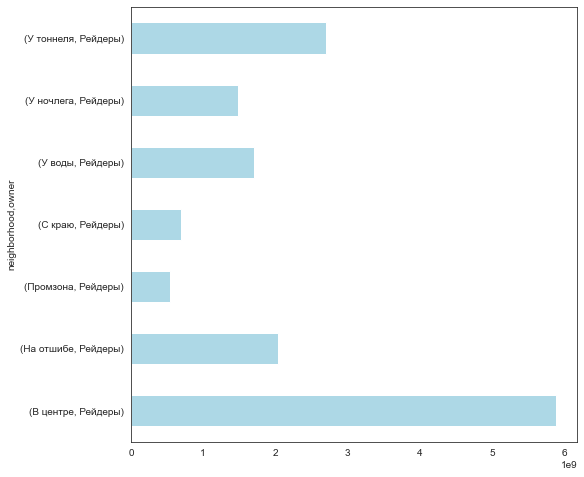

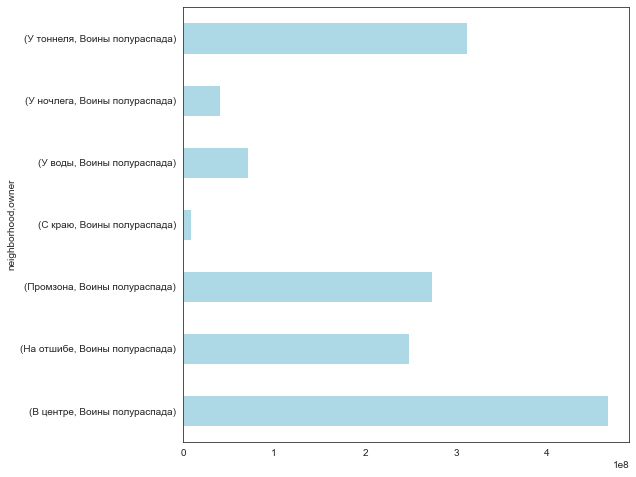

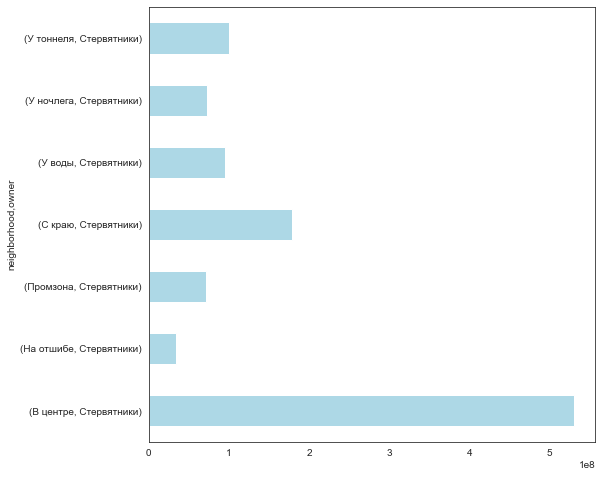

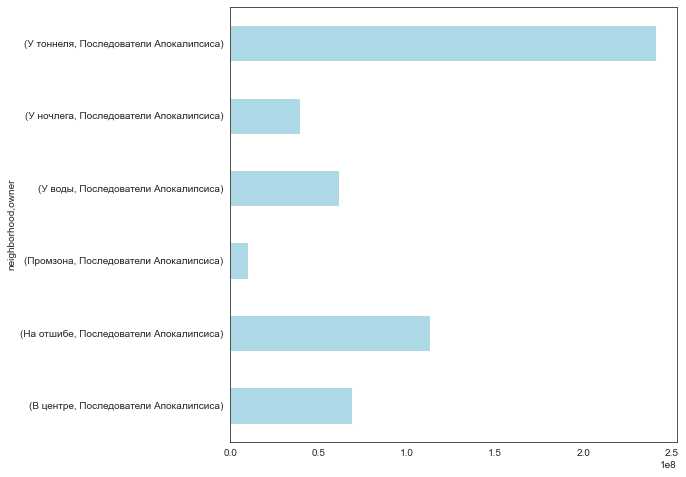

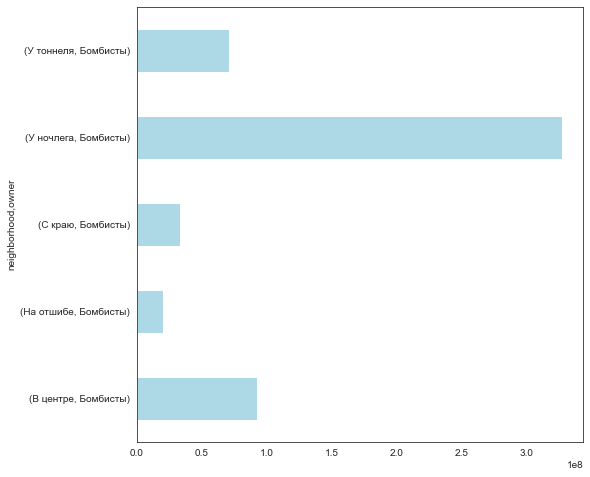

In [92]:
for i in pd.unique(mrg_sales_shops['owner']):
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    nn.query(f'owner=="{i}"')['total_items_sold'].plot.barh(ax=ax, color='lightblue')
    plt.show()

**Вывод**: мы можем сделать вывод о том, что `В центре` - наболее выгодное место для выручки. Далее идут `с краю` и `у тоннеля`. Итоговый результат следующий:

1. `В центре` - 0

2-3. `С краю`, `У тоннеля` - 9

4. `Промзона` - 13

5. `У ночлега` - 16

6. `На отшибе` - 20

7. `У воды` - 21

Можно взять признак в центре и у воды для кластеризации.

2. Теперь посмотрим на `shop_type` в разрезе `owner` и `goods_type`

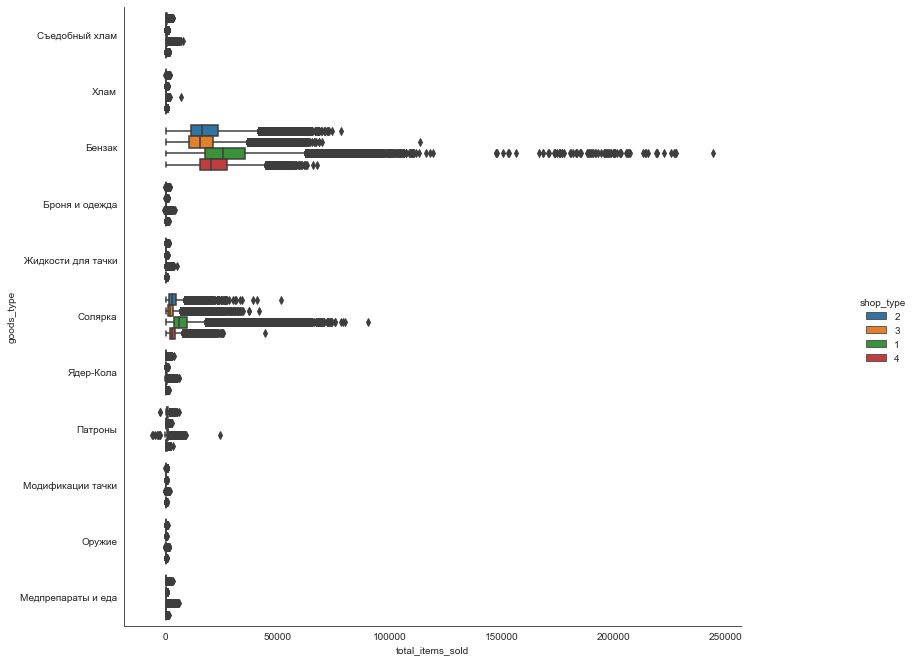

In [687]:
categorical = sns.catplot(y='goods_type', 
                          x='total_items_sold', 
                          hue='shop_type', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

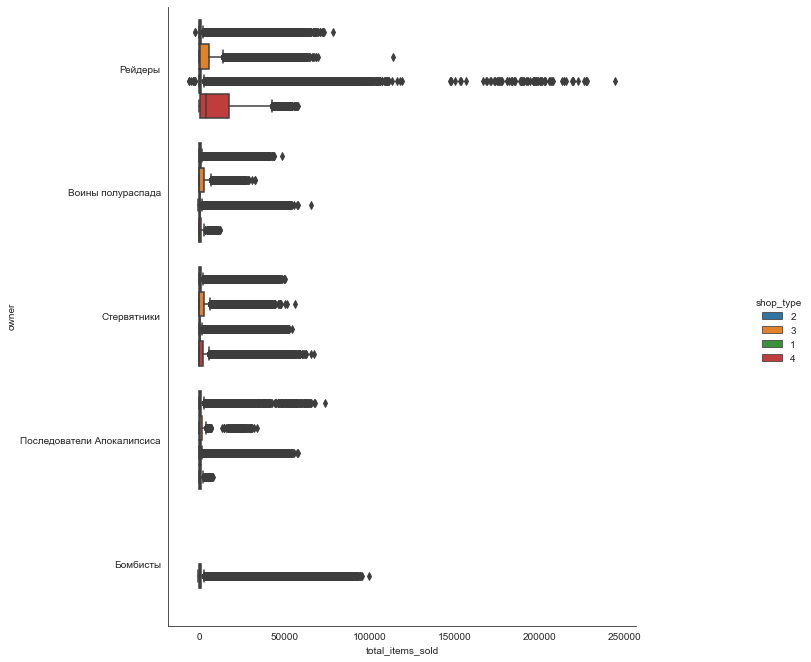

In [688]:
categorical = sns.catplot(y='owner', 
                          x='total_items_sold', 
                          hue='shop_type', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

**Вывод**: распределение в разрезе `shop_type` не показало, что есть какие-то различия в распределениях продажи товаров, а значит это не важный признак для кластеризации.

3. Для двух категориальных признаков про наличие колодца и у дороги сделаем то же самое.

`is_on_the_road`

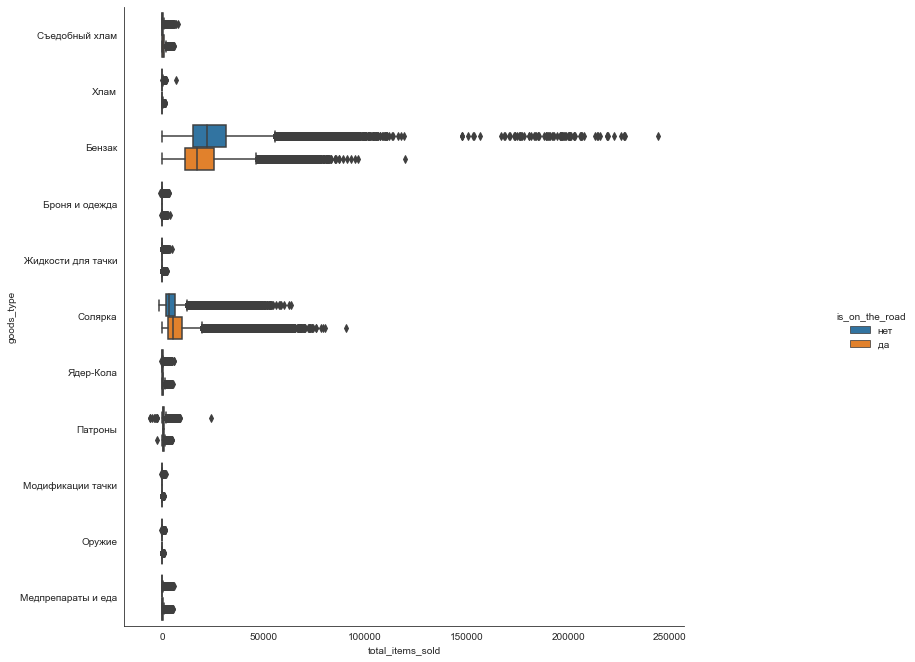

In [679]:
categorical = sns.catplot(y='goods_type', 
                          x='total_items_sold', 
                          hue='is_on_the_road', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

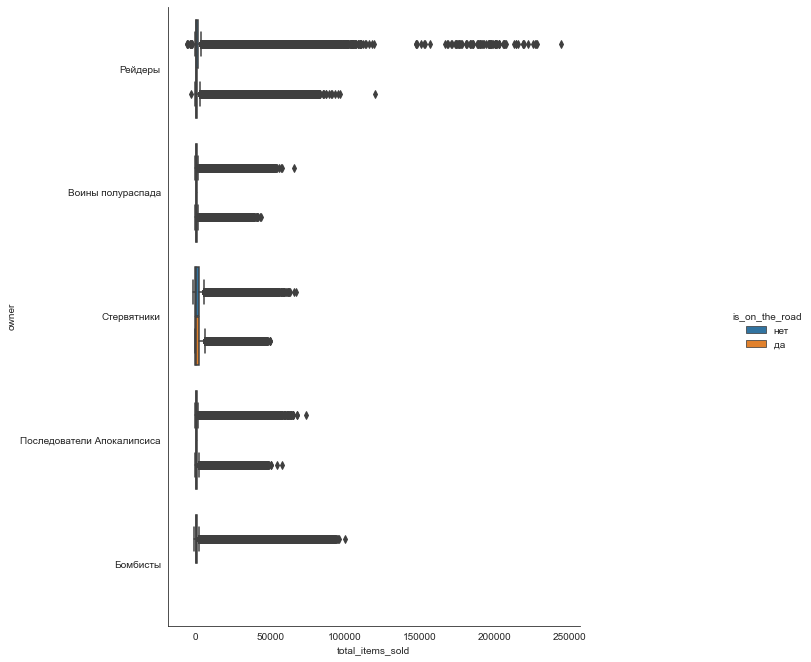

In [712]:
categorical = sns.catplot(y='owner', 
                          x='total_items_sold', 
                          hue='is_on_the_road', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

**Вывод**: чаще продают в магазинах не рядом с дорогой.

`is_with_the_well`

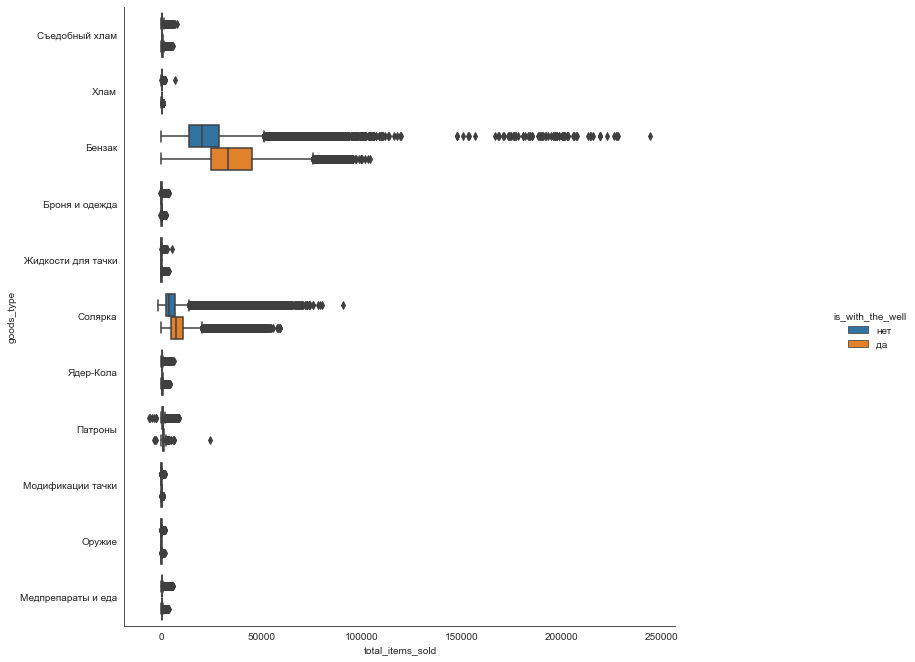

In [683]:
categorical = sns.catplot(y='goods_type', 
                          x='total_items_sold', 
                          hue='is_with_the_well', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

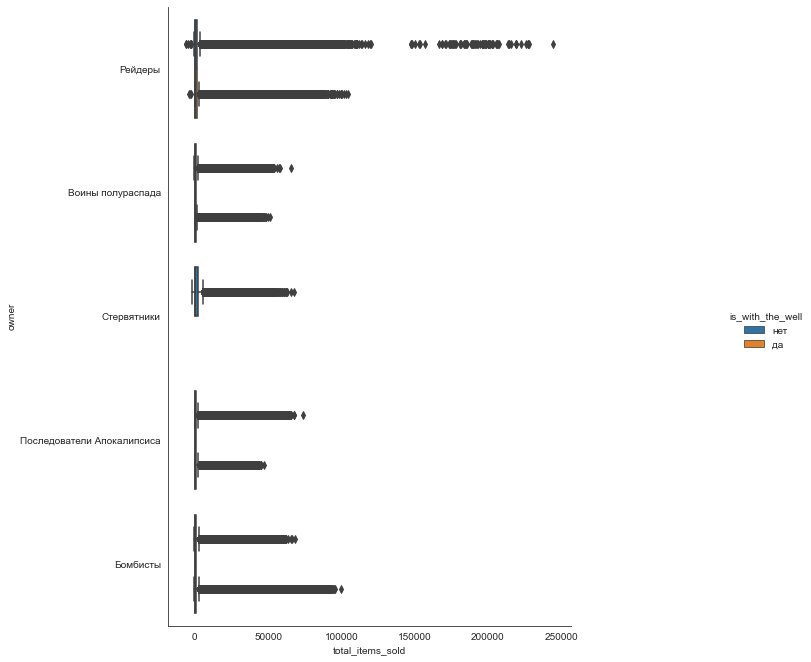

In [711]:
categorical = sns.catplot(y='owner', 
                          x='total_items_sold', 
                          hue='is_with_the_well', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

**Вывод**: признак не влияет на результат, удалим его из рассмотрения.

`is_with_additional_services`

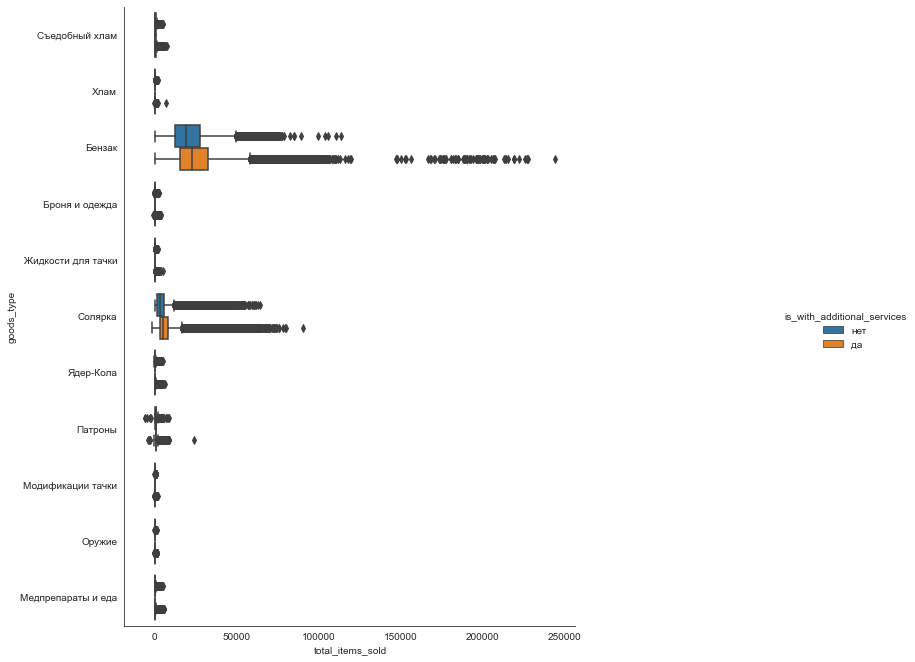

In [682]:
categorical = sns.catplot(y='goods_type', 
                          x='total_items_sold', 
                          hue='is_with_additional_services', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

Видно, что солярка продается больше в магазинах с `additional_services`

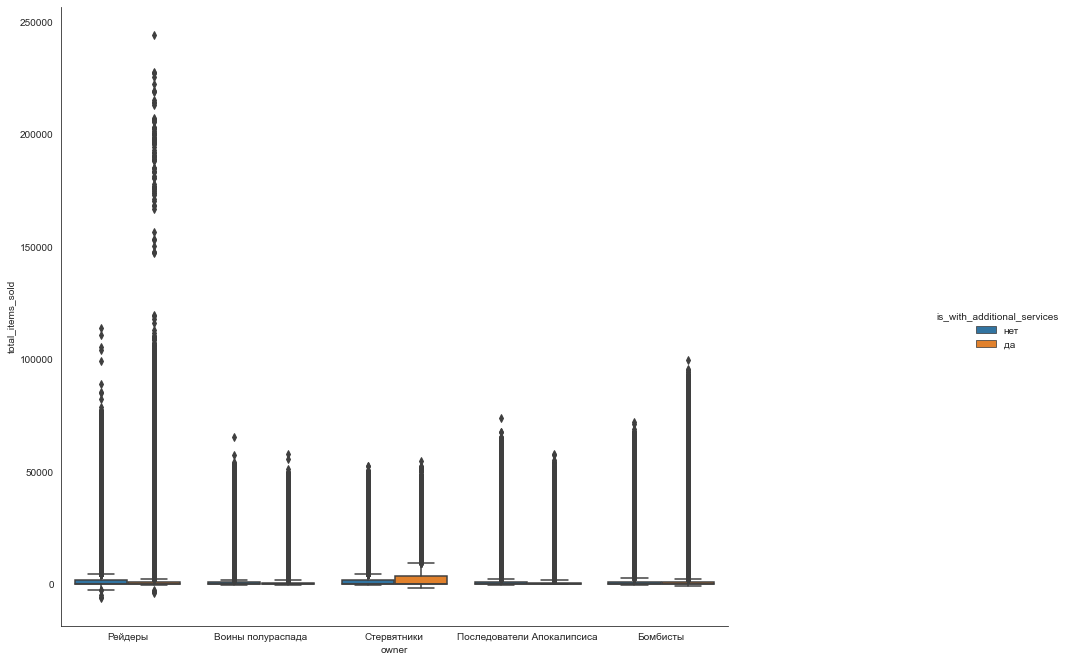

In [713]:
categorical = sns.catplot(x='owner', 
                          y='total_items_sold', 
                          hue='is_with_additional_services', 
                          kind="box", 
                          data=mrg_sales_shops)
categorical.fig.set_figwidth(17)
categorical.fig.set_figheight(10)

А стервятники имеют большую выручку, нежели остальные магазины.

**Вывод**: магазины с `additional_services` имеют большую выручку, это важный признак.

На данном этапе появилася **гипотеза кластеризации**: будем кластеризировать магазины по выгодности местоположения, откуда следует принадлежность определённому кластеру: маленькой, средней или большой компании, а так же, чем выгоднее местоположение, тем больше выручка с основных товаров, которые продаются в магазинах: `Солярка`, `Бензак`.

Это гипотеза звучит логично: разделим наши магазины на несколько групп по выгодности местоположения (у реки или в центре - разница есть), а из выгодности местоположения делается вывод о том, какая компания могла бы выкупить выгодное местоположение - очевидно, что богатая. Из выгодности местоположения вытекает увеличиние выручки.

## 2. Feature Engineering

Для лучшего управления магазинами, в частности, для более оптимального планирования промо-кампаний и прогнозирования спроса, вам необходимо `разбить магазины на кластеры похожих`. Единственный способ, которым пользовалась компания в прошлом – это разбитие по географическому признаку, то есть по городам. Но вы верите, что прочие характеристики магазинов, а самое главное, профили продаж магазинов, помогут сделать это гораздо точнее.

Вы должны изучить данные, выбрать метрику качества кластеризации, придумать и посчитать информативные признаки (например, доля продаж "патронов" по пятницам) и построить наиболее качественный алгоритм кластеризации, а также описать смысл каждого кластера в понятном для управляющих вашей **Компании** виде.

**Дополнительным плюсом** будет, если вы сможете обосновать, насколько построенная кластеризация лучше, чем разбитие просто по городам.


Сгенерируем матрицу признаков следующим образом.

Матрица состоит из следующих признаков:

- среднее количество `total_items_sold` по продуктам `Бензак`, `Оружие`, `Хлам`, `Броня и Одежда` - будем придерживаться данной стратегии - выбирать наилучшее по продажам среднее и наихудшее. После каждого добавления заполняем нулевые значения минус максимальным значеним в `dataframe`, чтобы обозначить различие между возникающими классами более явно.

- среднее количество по дню `day_name` - дню недели: `Friday` - min, `Monday` - mean, `Thursday` - max
- среднее количество продаж по наличию или отсутствию дополнительных сервисов.
- среднее количество продаж по `owner` - `Рейдеры` и `Бомбисты`

In [1527]:
X = pd.DataFrame(index=shops.index)
bensol = mrg_sales_shops.groupby(by=['shop_id', 'goods_type']).mean()
X[['mean_безак']] = pd.pivot_table(bensol.query("goods_type in ('Бензак')"), 
               index='shop_id', 
               columns='goods_type', 
               values='total_items_sold')
X[['mean_оружие', 'mean_хлам', 'mean_броня_и_одежда']] = \
                pd.pivot_table(bensol.query("goods_type in ('Оружие', 'Хлам', 'Броня и одежда')"), 
               index='shop_id', 
               columns='goods_type', 
               values='total_items_sold')
X = X.fillna(-X.max())
total_by_days = mrg_sales_shops.groupby(by=['shop_id', 'day_name']).mean()
X[['mean_friday', 'mean_monday', 'mean_thursday']] = pd.pivot_table(total_by_days.query("day_name in ('Friday', 'Monday', 'Thursday')"), 
               index='shop_id', 
               columns='day_name', 
               values='total_items_sold')
X = X.fillna(-X.max())
total_by_additional_services = mrg_sales_shops.groupby(by=['shop_id', 'is_with_additional_services']).mean()
X[['mean_without_add_services', 'mean_with_add_services']] = pd.pivot_table(total_by_additional_services,
               index='shop_id', 
               columns='is_with_additional_services', 
               values='total_items_sold')
X = X.fillna(-X.max())
mean_owner = mrg_sales_shops.groupby(by=['shop_id', 'owner']).sum()
X[['mean_рейдеры', 'mean_бомбисты']] = pd.pivot_table(mean_owner.query(
    "owner in ('Рейдеры', 'Бомбисты')"),
               index='shop_id', 
               columns='owner', 
               values='total_items_sold')

X = X.fillna(-X.max())

In [1528]:
X.head()

,mean_безак,mean_оружие,mean_хлам,mean_броня_и_одежда,mean_friday,mean_monday,mean_thursday,mean_without_add_services,mean_with_add_services,mean_рейдеры,mean_бомбисты
0,15955.706849,2.382353,-165.984263,19.579710,11665.776923,12384.565891,12778.931818,-27749.020548,12594.821622,-61535566.0,11650210.0
1,12471.384615,4.478261,-165.984263,14.151596,3101.419118,3856.400504,3400.805970,-27749.020548,3745.175395,-61535566.0,10655024.0
2,10939.730399,29.712121,12.953846,55.474341,1484.017773,1738.737725,1681.129505,1703.137827,-40769.784932,-61535566.0,10206905.0
3,31617.052126,2.922481,7.500000,28.044304,6539.016260,7534.930754,7393.818913,-27749.020548,7371.321005,-61535566.0,25512142.0
4,32128.467033,19.123098,12.231884,109.829670,3461.547521,4231.377709,3941.285141,4093.587600,-40769.784932,-61535566.0,28061543.0


## 3. Clustering

### 3.1 Metric of Clustering: `Silhouette`

Будем использовать метрику **silhouette** для качества кластеризации.

Для одного элемента $x$ она считается так:
$$S(x) = \frac{b(x) - a(x)}{\max{(a(x), b(x))}}$$

$a(x) =$ среднее расстояние от x до точек внутри того же кластера.

$b(x) = $ среднее расстояние от x до точек внутри ближайшего кластера.

Сама метрика равна среднему значению $S(x)$ от каждого элемента.

Видно, что $-1 \leq S(x) \leq 1$, причем чем больше $b(x)$ относительно $a(x)$, тем метрика ближе к $1$. Чем метрика больше - тем лучше кластеризация.

### 3.2 Clustering Method: `AgglomerativeClustering`

Интуиция у алгоритма очень простая:

1) Начинаем с того, что высыпаем на каждую точку свой кластер

2) Сортируем попарные расстояния между центрами кластеров по возрастанию

3) Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера

4) Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

Применим алгоритм `AgglomerativeClustering` к нашим признакам.

In [1529]:
k_range = np.arange(2, 9)
dict_results = {k: {'silhouette_score': 0, 'value_counts': 0} for k in k_range}

In [1530]:
for i in k_range:
    model = AgglomerativeClustering(n_clusters=i)
    y_pred = model.fit_predict(X)
    dict_results[i]['silhouette_score'] = silhouette_score(X, y_pred)
    dict_results[i]['value_counts'] = pd.value_counts(y_pred).to_dict()

In [1531]:
cluster_result = pd.DataFrame(dict_results).T
cluster_result 

,silhouette_score,value_counts
2,0.866026,"{1: 649, 0: 196}"
3,0.88943,"{0: 649, 2: 178, 1: 18}"
4,0.689217,"{1: 459, 3: 190, 2: 178, 0: 18}"
5,0.694719,"{0: 459, 1: 190, 2: 178, 4: 14, 3: 4}"
6,0.634455,"{1: 237, 2: 222, 0: 190, 5: 178, 4: 14, 3: 4}"
7,0.652384,"{1: 237, 2: 222, 5: 178, 0: 152, 6: 38, 4: 14,..."
8,0.647996,"{0: 237, 2: 222, 5: 178, 3: 101, 7: 51, 6: 38,..."


**Вывод**: выберем `n_clusters=3` в алгоритме `AgglomerativeClustering` - хорошее значение метрики, адекватное и, на самом деле, самое предсказуемое - мы примерно предполагали, что кластеров именно столько в самом простом приближении. Попытаемся понять, что это за кластеры.

## 4. ` -cluster: "Who am i ?"`

In [1532]:
model = AgglomerativeClustering(n_clusters=3)
y_pred = model.fit_predict(X)
X['n_cluster'] = y_pred

In [1536]:
shops['n_cluster'] = y_pred

In [1541]:
res = pd.merge(sales, shops, on='shop_id')

Посмотрим на некоторые аггрегированные статистики, которые помогут нам лучше сказать, что представляет из себя каждый кластер.

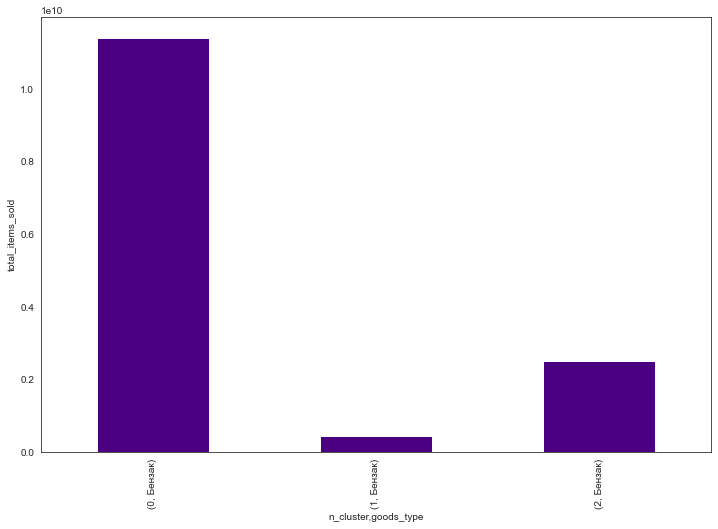

In [1570]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(
    res.groupby(by=['n_cluster', 'goods_type'])
    .sum()
    .query("goods_type in 'Бензак'")['total_items_sold']
    .plot.bar(color='indigo')
)
ax.set_ylabel('total_items_sold')
plt.show()

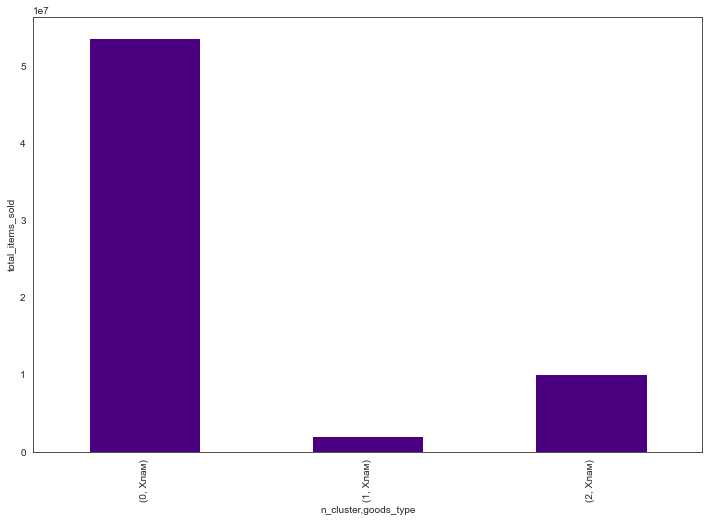

In [1571]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(
    res.groupby(by=['n_cluster', 'goods_type'])
    .sum()
    .query("goods_type in 'Хлам'")['total_items_sold']
    .plot.bar(color='indigo')
)
ax.set_ylabel('total_items_sold')
plt.show()

## 5. Submission

In [1579]:
submission = shops[['shop_id','n_cluster']]

In [1581]:
submission.to_csv('submission.tsv', index=False)